In [1]:
pip install -U scikit-learn imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --user -U scikit-learn imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
from sklearn.pipeline import make_pipeline


In [4]:
client_data = pd.read_csv("client_data.csv")
price_data = pd.read_csv("price_data.csv")

#### Data types

In [5]:
price_data.dtypes

id                     object
price_date             object
price_off_peak_var    float64
price_peak_var        float64
price_mid_peak_var    float64
price_off_peak_fix    float64
price_peak_fix        float64
price_mid_peak_fix    float64
dtype: object

In [6]:
client_data.dtypes

id                                 object
channel_sales                      object
cons_12m                            int64
cons_gas_12m                        int64
cons_last_month                     int64
date_activ                         object
date_end                           object
date_modif_prod                    object
date_renewal                       object
forecast_cons_12m                 float64
forecast_cons_year                  int64
forecast_discount_energy          float64
forecast_meter_rent_12m           float64
forecast_price_energy_off_peak    float64
forecast_price_energy_peak        float64
forecast_price_pow_off_peak       float64
has_gas                            object
imp_cons                          float64
margin_gross_pow_ele              float64
margin_net_pow_ele                float64
nb_prod_act                         int64
net_margin                        float64
num_years_antig                     int64
origin_up                         

#### Descriptive statistics

##### Information

In [7]:
client_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

In [8]:
price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  193002 non-null  object 
 1   price_date          193002 non-null  object 
 2   price_off_peak_var  193002 non-null  float64
 3   price_peak_var      193002 non-null  float64
 4   price_mid_peak_var  193002 non-null  float64
 5   price_off_peak_fix  193002 non-null  float64
 6   price_peak_fix      193002 non-null  float64
 7   price_mid_peak_fix  193002 non-null  float64
dtypes: float64(6), object(2)
memory usage: 11.8+ MB


##### Summary

In [9]:
client_data.describe()

cons_12m  cons_gas_12m  cons_last_month  forecast_cons_12m  \
count  1.460600e+04  1.460600e+04     14606.000000       14606.000000   
mean   1.592203e+05  2.809238e+04     16090.269752        1868.614880   
std    5.734653e+05  1.629731e+05     64364.196422        2387.571531   
min    0.000000e+00  0.000000e+00         0.000000           0.000000   
25%    5.674750e+03  0.000000e+00         0.000000         494.995000   
50%    1.411550e+04  0.000000e+00       792.500000        1112.875000   
75%    4.076375e+04  0.000000e+00      3383.000000        2401.790000   
max    6.207104e+06  4.154590e+06    771203.000000       82902.830000   

       forecast_cons_year  forecast_discount_energy  forecast_meter_rent_12m  \
count        14606.000000              14606.000000             14606.000000   
mean          1399.762906                  0.966726                63.086871   
std           3247.786255                  5.108289                66.165783   
min              0.000000                  0.000000                 0.000000   
25%              0.000000                  0.000000                16.180000   
50%            314.000000                  0.000000                18.795000   
75%           1745.750000                  0.000000               131.030000   
max         175375.000000                 30.000000               599.310000   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
count                    14606.000000                14606.000000   
mean                         0.137283                    0.050491   
std                          0.024623                    0.049037   
min                          0.000000                    0.000000   
25%                          0.116340                    0.000000   
50%                          0.143166                    0.084138   
75%                          0.146348                    0.098837   
max                          0.273963                    0.195975   

       forecast_price_pow_off_peak      imp_cons  margin_gross_pow_ele  \
count                 14606.000000  14606.000000          14606.000000   
mean                     43.130056    152.786896             24.565121   
std                       4.485988    341.369366             20.231172   
min                       0.000000      0.000000              0.000000   
25%                      40.606701      0.000000             14.280000   
50%                      44.311378     37.395000             21.640000   
75%                      44.311378    193.980000             29.880000   
max                      59.266378  15042.790000            374.640000   

       margin_net_pow_ele   nb_prod_act    net_margin  num_years_antig  \
count        14606.000000  14606.000000  14606.000000     14606.000000   
mean            24.562517      1.292346    189.264522         4.997809   
std             20.230280      0.709774    311.798130         1.611749   
min              0.000000      1.000000      0.000000         1.000000   
25%             14.280000      1.000000     50.712500         4.000000   
50%             21.640000      1.000000    112.530000         5.000000   
75%             29.880000      1.000000    243.097500         6.000000   
max            374.640000     32.000000  24570.650000        13.000000   

            pow_max         churn  
count  14606.000000  14606.000000  
mean      18.135136      0.097152  
std       13.534743      0.296175  
min        3.300000      0.000000  
25%       12.500000      0.000000  
50%       13.856000      0.000000  
75%       19.172500      0.000000  
max      320.000000      1.000000

In [10]:
price_data.describe()

price_off_peak_var  price_peak_var  price_mid_peak_var  \
count       193002.000000   193002.000000       193002.000000   
mean             0.141027        0.054630            0.030496   
std              0.025032        0.049924            0.036298   
min              0.000000        0.000000            0.000000   
25%              0.125976        0.000000            0.000000   
50%              0.146033        0.085483            0.000000   
75%              0.151635        0.101673            0.072558   
max              0.280700        0.229788            0.114102   

       price_off_peak_fix  price_peak_fix  price_mid_peak_fix  
count       193002.000000   193002.000000       193002.000000  
mean            43.334477       10.622875            6.409984  
std              5.410297       12.841895            7.773592  
min              0.000000        0.000000            0.000000  
25%             40.728885        0.000000            0.000000  
50%             44.266930        0.000000            0.000000  
75%             44.444710       24.339581           16.226389  
max             59.444710       36.490692           17.458221

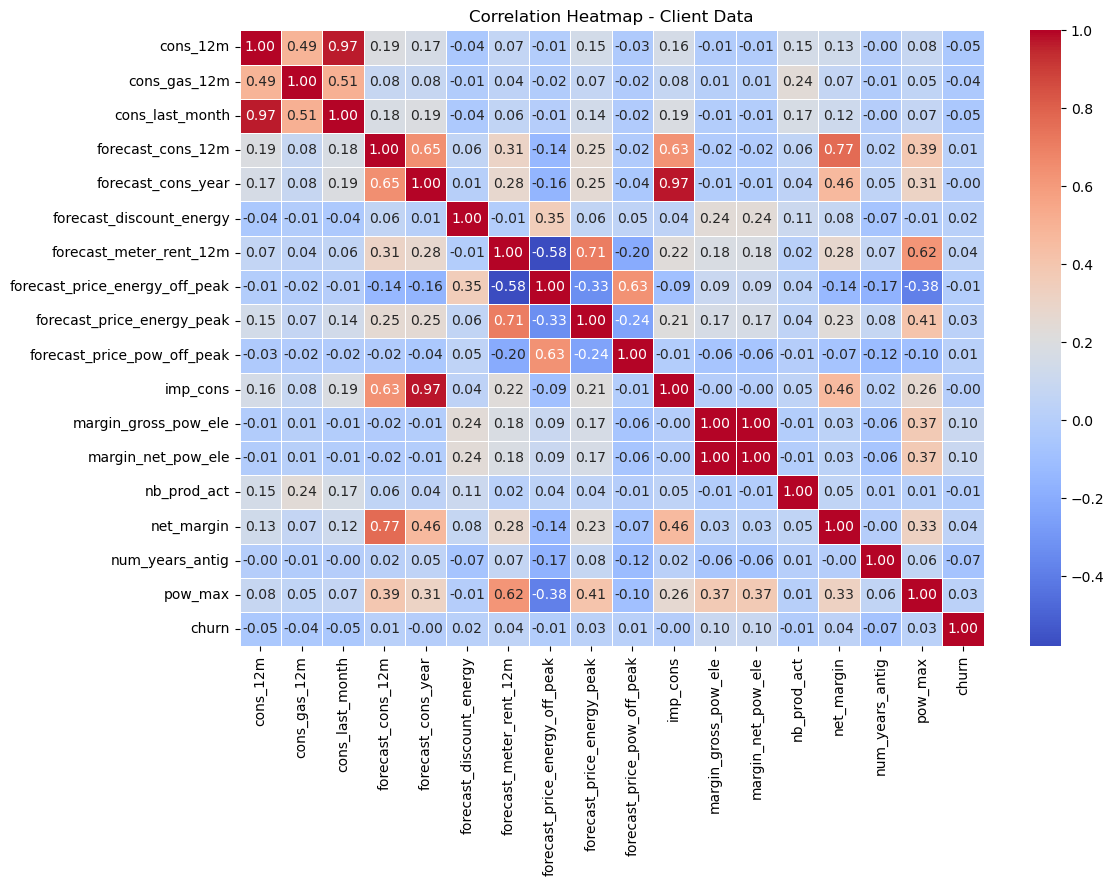

In [12]:
client_data_numeric_columns = client_data.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(12, 8))
sns.heatmap(client_data_numeric_columns.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap - Client Data')
plt.show()

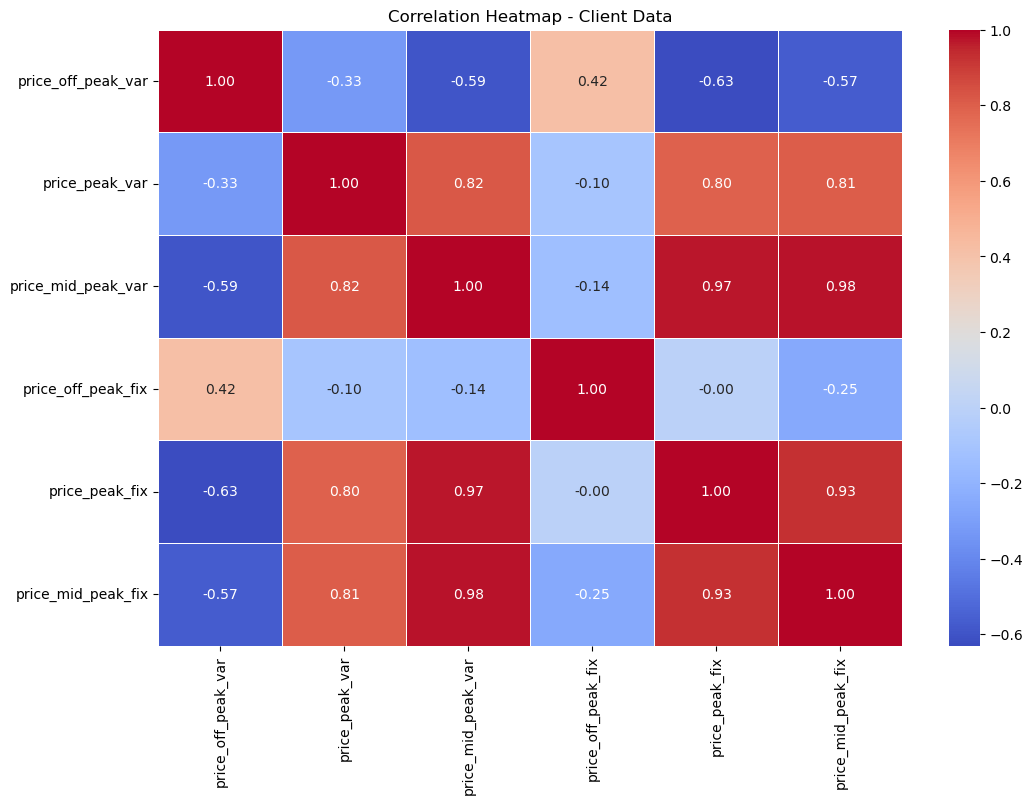

In [13]:
price_data_numeric_columns = price_data.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(12, 8))
sns.heatmap(price_data_numeric_columns.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap - Client Data')
plt.show()

#### Distribution of Client Data

C:\Users\kariu\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


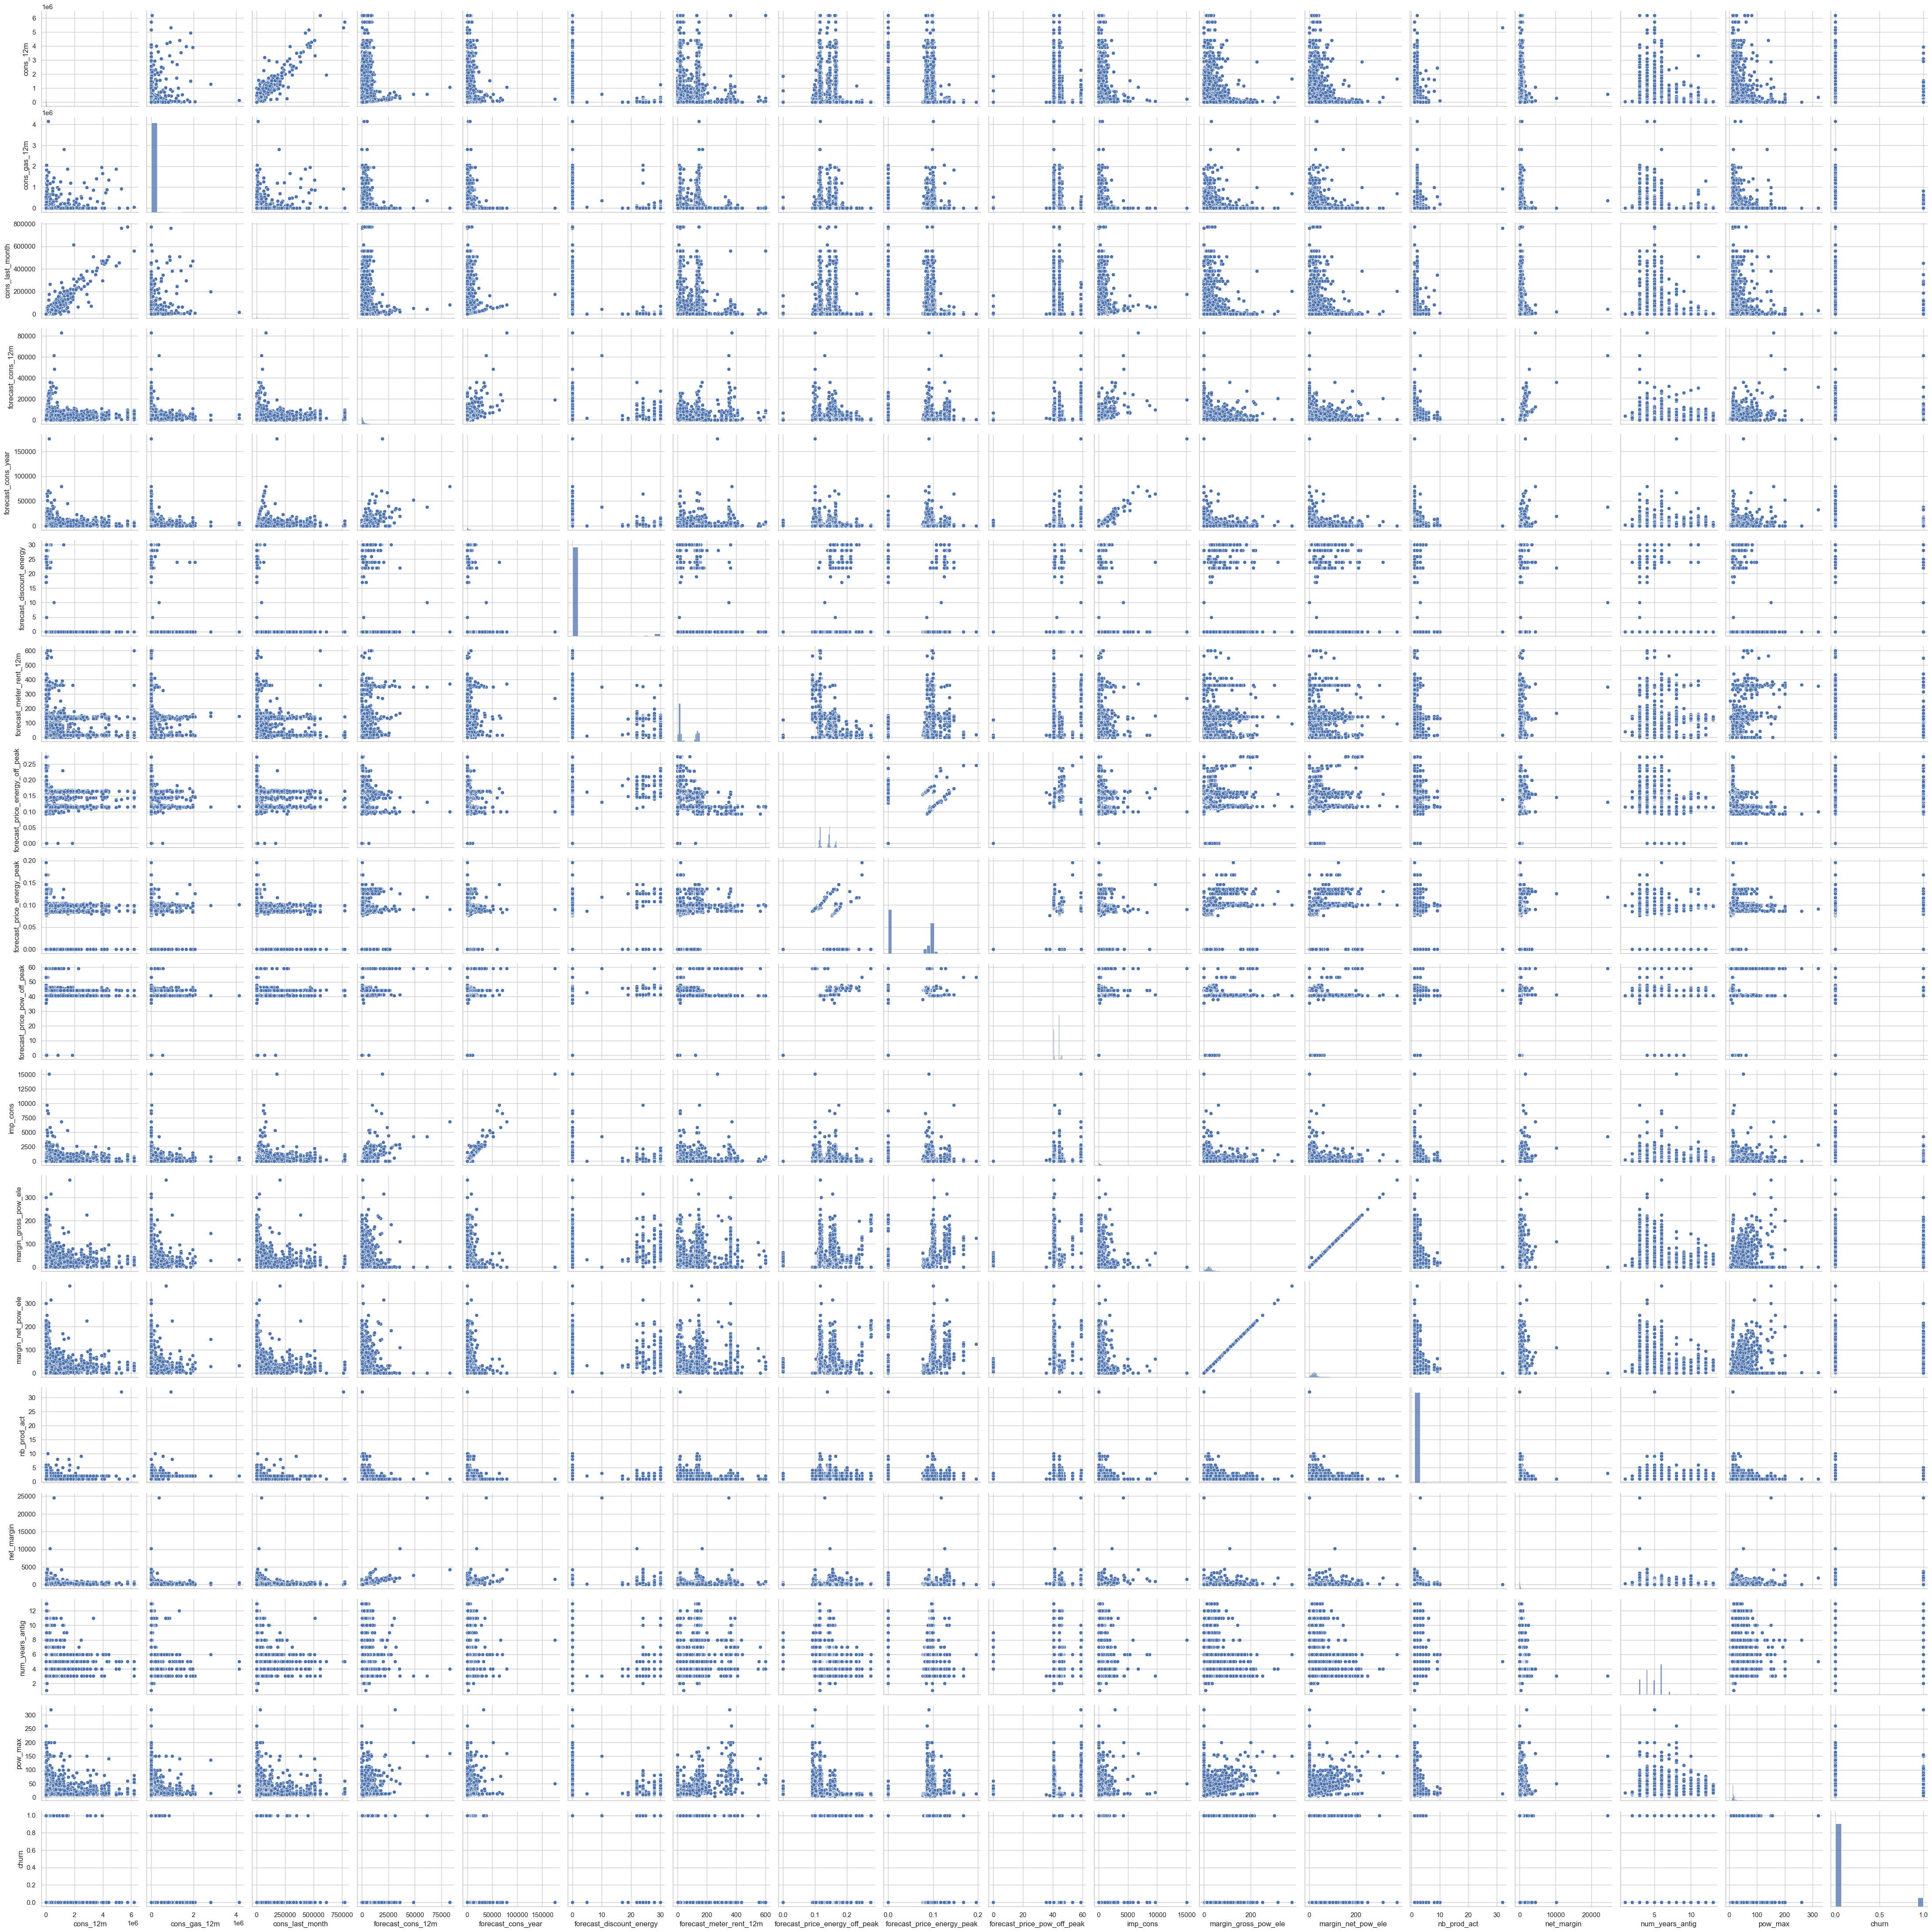

In [14]:
sns.set(style="whitegrid")

numeric_columns = client_data.select_dtypes(include=['float64', 'int64'])

# Create a pairplot
sns.pairplot(numeric_columns)
plt.show()

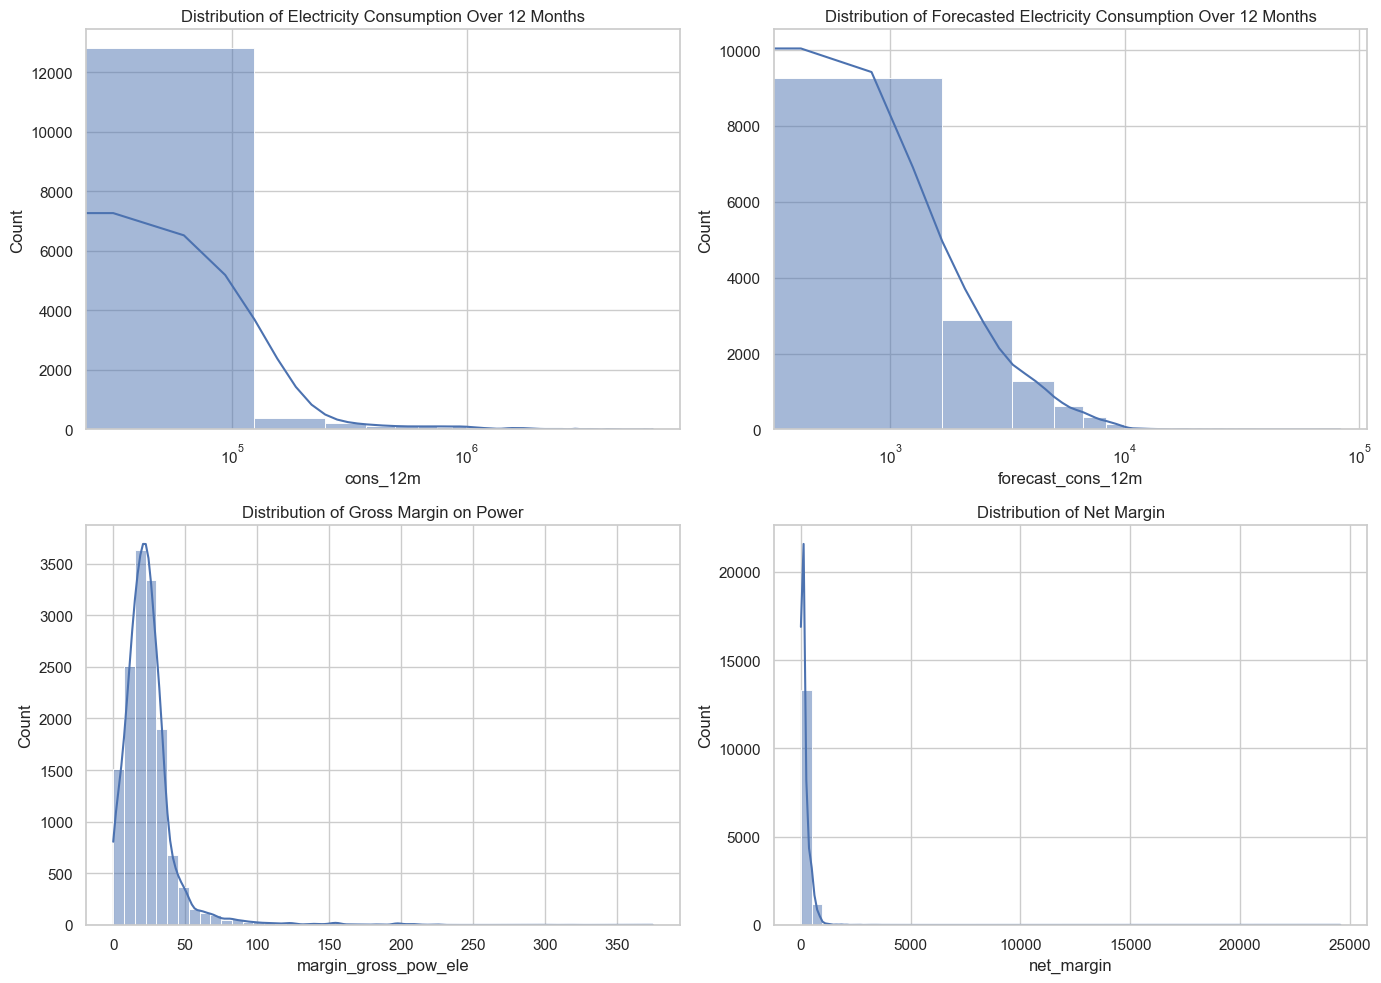

In [15]:
# Set the style of seaborn
sns.set(style='whitegrid')

# Plotting distributions of a few numerical columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Distribution of electricity consumption over 12 months
sns.histplot(client_data['cons_12m'], bins=50, ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Distribution of Electricity Consumption Over 12 Months')
axes[0, 0].set_xscale('log')

# Distribution of forecasted electricity consumption over 12 months
sns.histplot(client_data['forecast_cons_12m'], bins=50, ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Distribution of Forecasted Electricity Consumption Over 12 Months')
axes[0, 1].set_xscale('log')

# Distribution of gross margin on power
sns.histplot(client_data['margin_gross_pow_ele'], bins=50, ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Distribution of Gross Margin on Power')

# Distribution of net margin
sns.histplot(client_data['net_margin'], bins=50, ax=axes[1, 1], kde=True)
axes[1, 1].set_title('Distribution of Net Margin')

plt.tight_layout()
plt.show()

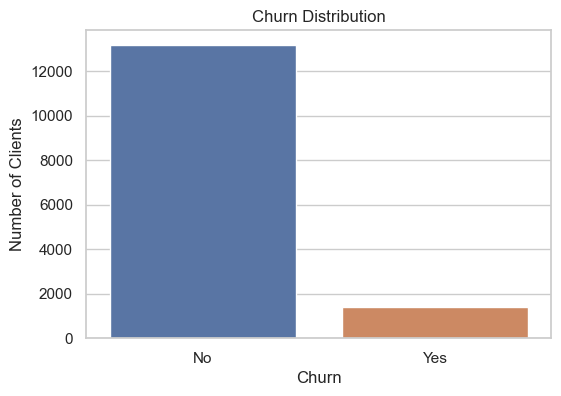

In [16]:
sns.set(style='whitegrid')

# Plotting the churn distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='churn', data=client_data)
plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Number of Clients')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

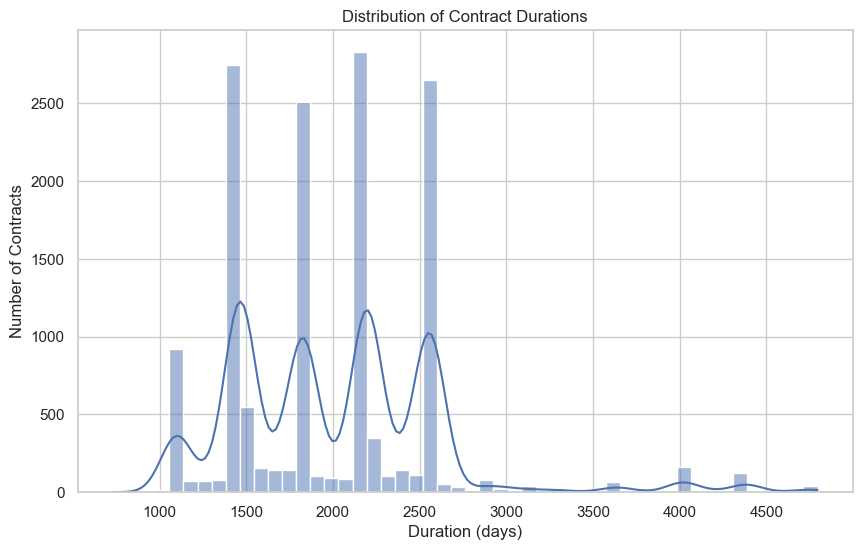

In [17]:
# Convert date columns to datetime
client_data['date_activ'] = pd.to_datetime(client_data['date_activ'], format='%Y-%m-%d')
client_data['date_end'] = pd.to_datetime(client_data['date_end'], format='%Y-%m-%d', errors='coerce')
client_data['date_modif_prod'] = pd.to_datetime(client_data['date_modif_prod'], format='%Y-%m-%d', errors='coerce')
client_data['date_renewal'] = pd.to_datetime(client_data['date_renewal'], format='%Y-%m-%d', errors='coerce')

# Calculate the duration of the contract in days
client_data['contract_duration'] = (client_data['date_end'] - client_data['date_activ']).dt.days

# Replace negative and NaN values with the median duration
median_duration = client_data['contract_duration'].median()
client_data['contract_duration'] = client_data['contract_duration'].apply(lambda x: median_duration if x < 0 or pd.isna(x) else x)

# Show the distribution of contract durations
plt.figure(figsize=(10, 6))
sns.histplot(client_data['contract_duration'], bins=50, kde=True)
plt.title('Distribution of Contract Durations')
plt.xlabel('Duration (days)')
plt.ylabel('Number of Contracts')
plt.show()

In [18]:
# Calculate the average consumption and margins
client_data['average_consumption'] = client_data[['cons_12m', 'cons_gas_12m', 'cons_last_month']].mean(axis=1)
client_data['average_margin'] = client_data[['margin_gross_pow_ele', 'margin_net_pow_ele']].mean(axis=1)

# Calculate the average forecast consumption and price
client_data['average_forecast_cons'] = client_data[['forecast_cons_12m', 'forecast_cons_year']].mean(axis=1)
client_data['average_forecast_price'] = client_data[['forecast_price_energy_off_peak', 'forecast_price_energy_peak', 'forecast_price_pow_off_peak']].mean(axis=1)

# Summary statistics for the new average columns
summary_statistics = client_data[['average_consumption', 'average_margin', 'average_forecast_cons', 'average_forecast_price']].describe()

# Display the summary statistics
summary_statistics

average_consumption  average_margin  average_forecast_cons  \
count         1.460600e+04    14606.000000           14606.000000   
mean          6.780098e+04       24.563819            1634.188893   
std           2.433520e+05       20.230291            2563.882762   
min           0.000000e+00        0.000000               0.000000   
25%           2.225750e+03       14.280000             334.300000   
50%           5.814667e+03       21.640000             839.617500   
75%           1.797083e+04       29.880000            2026.855000   
max           2.408666e+06      374.640000           97280.390000   

       average_forecast_price  
count            14606.000000  
mean                14.439277  
std                  1.496629  
min                  0.000000  
25%                 13.608061  
50%                 14.818318  
75%                 14.852151  
max                 19.846780

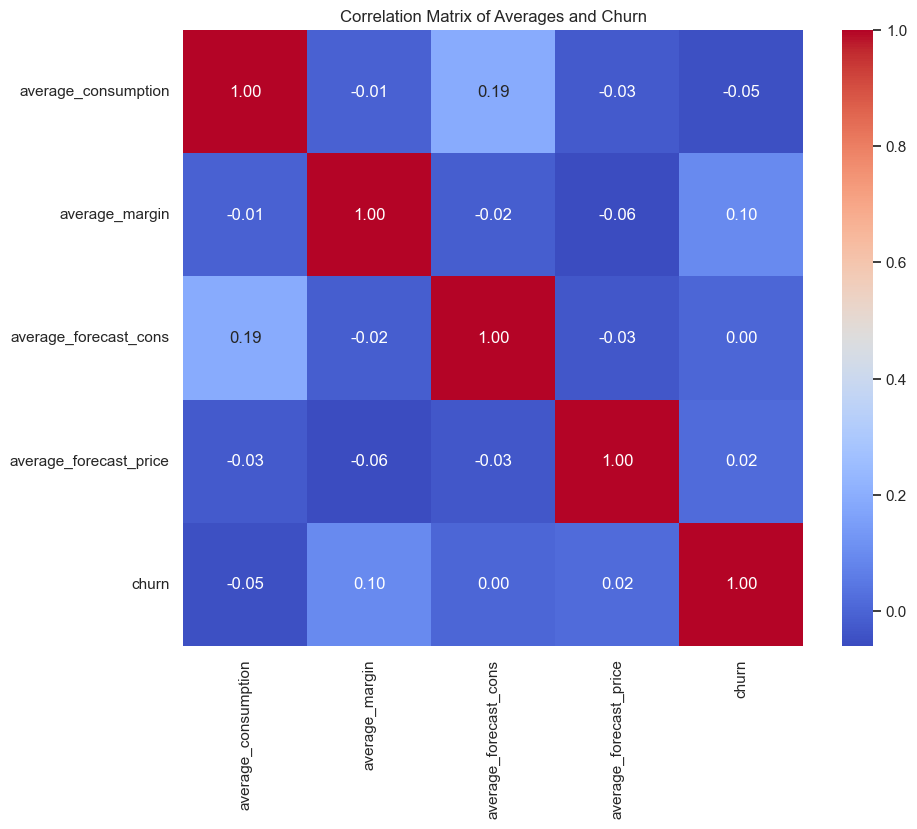

In [19]:
# Correlation matrix of the newly calculated averages and churn
# Selecting relevant columns for correlation
columns_of_interest = ['average_consumption', 'average_margin', 'average_forecast_cons', 'average_forecast_price', 'churn']
correlation_matrix = client_data[columns_of_interest].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Averages and Churn')
plt.show()

In [20]:
# Preparing the data for logistic regression
X = client_data[['average_consumption', 'average_margin', 'average_forecast_cons', 'average_forecast_price']]
y = client_data['churn']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the logistic regression model
log_reg = LogisticRegression()

# Fitting the model
log_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred = log_reg.predict(X_test)

# Generating the classification report and confusion matrix
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Output the classification report and confusion matrix
print('Classification Report:\n', report)
print('Confusion Matrix:\n', conf_matrix)

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94      2617
           1       0.04      0.00      0.01       305

    accuracy                           0.89      2922
   macro avg       0.47      0.50      0.47      2922
weighted avg       0.81      0.89      0.84      2922

Confusion Matrix:
 [[2595   22]
 [ 304    1]]


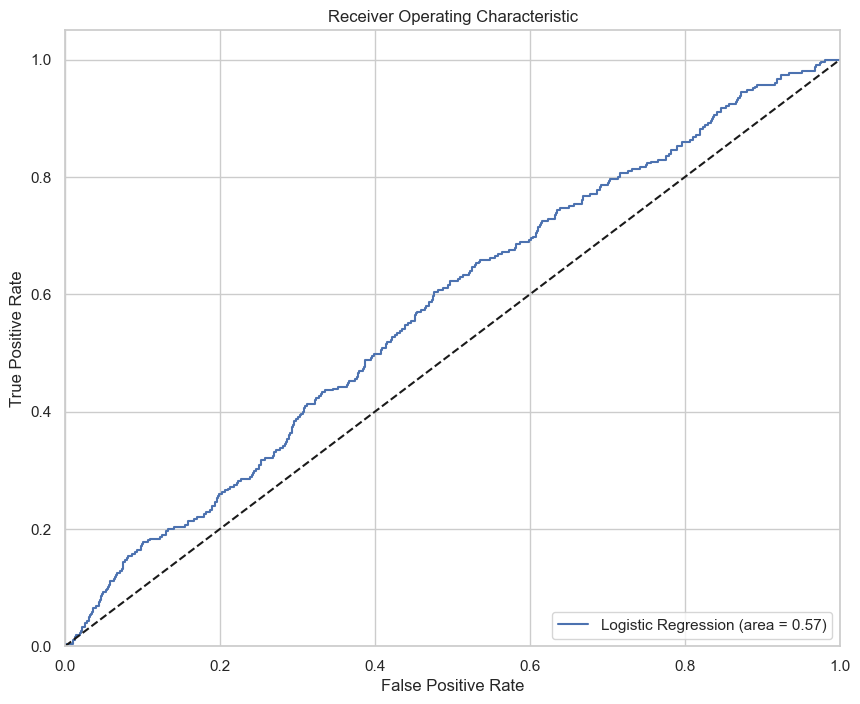

In [21]:
# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])

# Plotting the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [22]:
# Define a parameter grid to search for the best parameters for random forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

# Create a base model
rf = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring = 'roc_auc')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_

# Output the best parameters
print('Best parameters found:\n', best_params)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


C:\Users\kariu\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
43 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kariu\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kariu\anaconda3\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\kariu\anaconda3\Lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\kariu\anaconda3\Lib\site-packages

Best parameters found:
 {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 200}


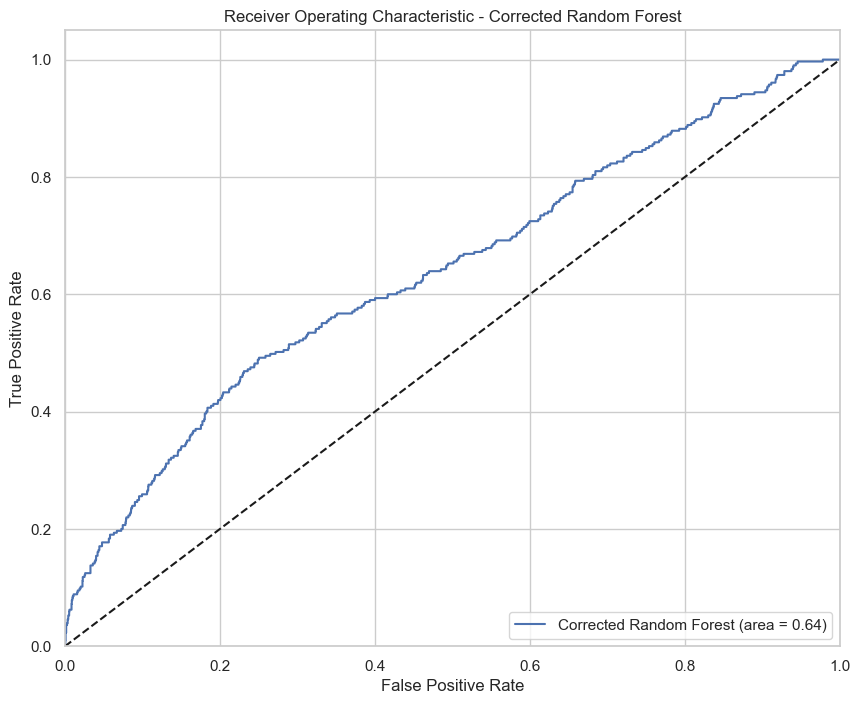

In [23]:
# Correcting the 'max_features' parameter and rebuilding the RandomForestClassifier
# 'auto' is equivalent to 'sqrt', so we will use 'sqrt' instead
rf_best_corrected = RandomForestClassifier(criterion='entropy', max_depth=8, max_features='sqrt', n_estimators=200, random_state=42)

# Fitting the model
rf_best_corrected.fit(X_train, y_train)

# Predicting on the test set
y_pred_rf_corrected = rf_best_corrected.predict(X_test)

# Calculate the ROC AUC score for the corrected random forest model
roc_auc_rf_corrected = roc_auc_score(y_test, rf_best_corrected.predict_proba(X_test)[:, 1])

# Calculate the ROC curve for the corrected random forest model
fpr_rf_corrected, tpr_rf_corrected, thresholds_rf_corrected = roc_curve(y_test, rf_best_corrected.predict_proba(X_test)[:, 1])

# Plotting the ROC curve for the corrected random forest model
plt.figure(figsize=(10, 8))
plt.plot(fpr_rf_corrected, tpr_rf_corrected, label='Corrected Random Forest (area = %0.2f)' % roc_auc_rf_corrected)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Corrected Random Forest')
plt.legend(loc='lower right')
plt.show()

In [24]:
# Generating the classification report
report_rf_corrected = classification_report(y_test, y_pred_rf_corrected)

# Generating the confusion matrix
conf_matrix_rf_corrected = confusion_matrix(y_test, y_pred_rf_corrected)

# Output the classification report and confusion matrix
print('Classification Report for Corrected Random Forest:\n', report_rf_corrected)
print('Confusion Matrix for Corrected Random Forest:\n', conf_matrix_rf_corrected)

Classification Report for Corrected Random Forest:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      2617
           1       1.00      0.00      0.01       305

    accuracy                           0.90      2922
   macro avg       0.95      0.50      0.48      2922
weighted avg       0.91      0.90      0.85      2922

Confusion Matrix for Corrected Random Forest:
 [[2617    0]
 [ 304    1]]


In [31]:
# Given the poor performance of the model on the minority class (churn), we should consider using SMOTE (Synthetic Minority Over-sampling Technique)
# to balance the dataset and improve the model's ability to predict churn.
from imblearn.over_sampling import SMOTE

# Applying SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Checking the balance of the classes after applying SMOTE
print("After SMOTE, counts of label '1': {}".format(sum(y_train_smote == 1)))
print("After SMOTE, counts of label '0': {}".format(sum(y_train_smote == 0)))

# Rebuilding the RandomForestClassifier with the best parameters on the balanced dataset
rf_best_smote = RandomForestClassifier(criterion='entropy', max_depth=8, max_features='sqrt', n_estimators=200, random_state=42)
rf_best_smote.fit(X_train_smote, y_train_smote)

# Predicting on the test set
y_pred_rf_smote = rf_best_smote.predict(X_test)

# Generating the classification report and confusion matrix for the SMOTE-adjusted Random Forest model
report_rf_smote = classification_report(y_test, y_pred_rf_smote)
conf_matrix_rf_smote = confusion_matrix(y_test, y_pred_rf_smote)

# Output the classification report and confusion matrix
print('Classification Report for SMOTE-adjusted Random Forest:\n', report_rf_smote)
print('Confusion Matrix for SMOTE-adjusted Random Forest:\n', conf_matrix_rf_smote)

After SMOTE, counts of label '1': 10570
After SMOTE, counts of label '0': 10570
Classification Report for SMOTE-adjusted Random Forest:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90      2617
           1       0.18      0.18      0.18       305

    accuracy                           0.83      2922
   macro avg       0.54      0.54      0.54      2922
weighted avg       0.83      0.83      0.83      2922

Confusion Matrix for SMOTE-adjusted Random Forest:
 [[2366  251]
 [ 250   55]]


In [33]:
# Applying SMOTEENN to the training data
smote_enn = SMOTEENN(random_state=42)
X_train_smoteenn, y_train_smoteenn = smote_enn.fit_resample(X_train, y_train)

# Checking the balance of the classes after applying SMOTEENN
print('After SMOTEENN, counts of label "1": {}'.format(sum(y_train_smoteenn == 1)))
print('After SMOTEENN, counts of label "0": {}'.format(sum(y_train_smoteenn == 0)))

# Rebuilding the RandomForestClassifier with the best parameters on the new balanced dataset
rf_best_smoteenn = RandomForestClassifier(criterion='entropy', max_depth=8, max_features='sqrt', n_estimators=200, random_state=42)
rf_best_smoteenn.fit(X_train_smoteenn, y_train_smoteenn)

# Predicting on the test set
y_pred_rf_smoteenn = rf_best_smoteenn.predict(X_test)

# Generating the classification report and confusion matrix for the SMOTEENN-adjusted Random Forest model
report_rf_smoteenn = classification_report(y_test, y_pred_rf_smoteenn)
conf_matrix_rf_smoteenn = confusion_matrix(y_test, y_pred_rf_smoteenn)

# Output the classification report and confusion matrix
print('Classification Report for SMOTEENN-adjusted Random Forest:\n', report_rf_smoteenn)
print('Confusion Matrix for SMOTEENN-adjusted Random Forest:\n', conf_matrix_rf_smoteenn)

After SMOTEENN, counts of label "1": 6651
After SMOTEENN, counts of label "0": 5478
Classification Report for SMOTEENN-adjusted Random Forest:
               precision    recall  f1-score   support

           0       0.91      0.72      0.81      2617
           1       0.15      0.43      0.22       305

    accuracy                           0.69      2922
   macro avg       0.53      0.57      0.51      2922
weighted avg       0.84      0.69      0.74      2922

Confusion Matrix for SMOTEENN-adjusted Random Forest:
 [[1883  734]
 [ 175  130]]


The accuracy of the prediction models evolved through the analysis:

The initial Random Forest model had a high accuracy for the non-churn class but failed to identify churn cases effectively.
After applying SMOTE to balance the dataset, the model's ability to predict churn improved, with a slight decrease in overall accuracy.
The SMOTEENN-adjusted Random Forest model further balanced the precision and recall for the minority class, but the overall accuracy was reduced compared to the previous models.
The trade-off between class balance and overall accuracy was evident, with each model adjustment aiming to improve the minority class prediction at the cost of reduced overall accuracy.

### Distribution of Price data

C:\Users\kariu\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


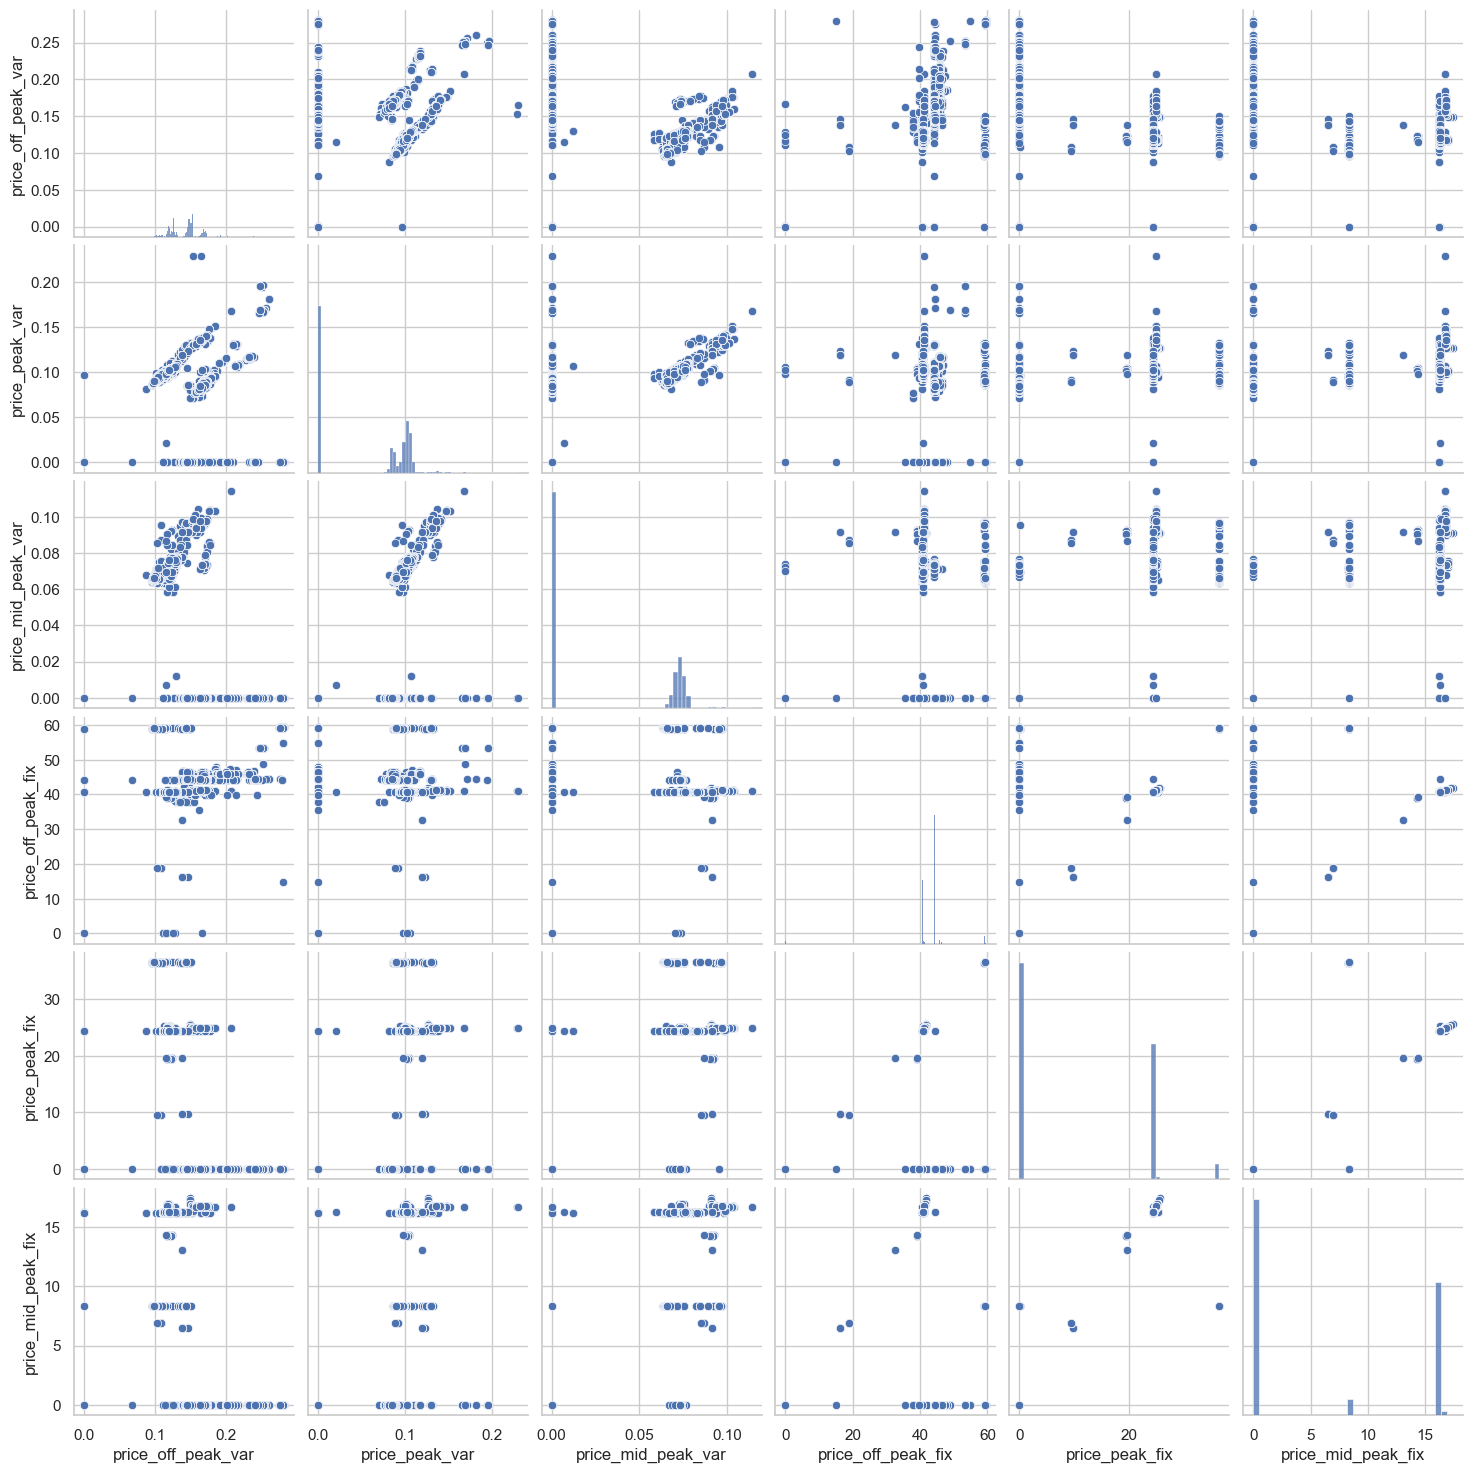

In [22]:
sns.set(style="whitegrid")

numeric_columns = price_data.select_dtypes(include=['float64', 'int64'])

# Create a pairplot
sns.pairplot(numeric_columns)
plt.show()

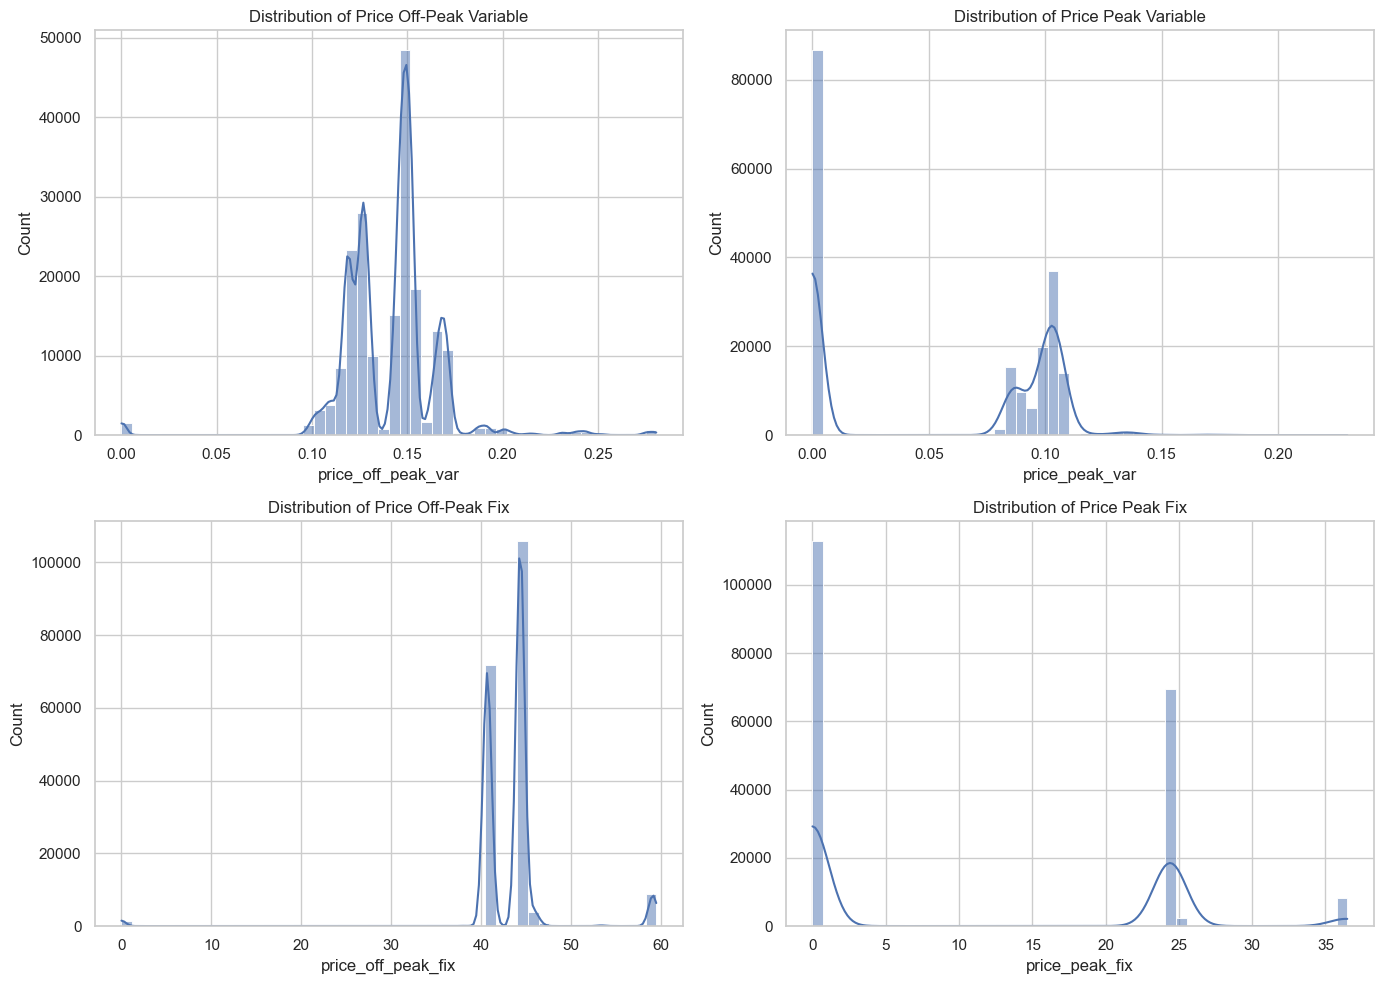

In [34]:
# Set the style of seaborn
sns.set(style='whitegrid')

# Plotting distributions of a few numerical columns in price data
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Distribution of price_off_peak_var
sns.histplot(price_data['price_off_peak_var'], bins=50, ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Distribution of Price Off-Peak Variable')

# Distribution of price_peak_var
sns.histplot(price_data['price_peak_var'], bins=50, ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Distribution of Price Peak Variable')

# Distribution of price_off_peak_fix
sns.histplot(price_data['price_off_peak_fix'], bins=50, ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Distribution of Price Off-Peak Fix')

# Distribution of price_peak_fix
sns.histplot(price_data['price_peak_fix'], bins=50, ax=axes[1, 1], kde=True)
axes[1, 1].set_title('Distribution of Price Peak Fix')

plt.tight_layout()
plt.show()


In [48]:
# Merge the two datasets on the 'id' column to see how they relate
combined_data = pd.merge(client_data, price_data, on='id', how='inner')

# Display the head of the merged dataset to verify the merge
print(combined_data.head())

# Provide a summary of the combined dataset
print('\nCombined Data Description:')
combined_data.describe

                                 id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
2  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
3  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
4  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   
1         0         54946                0 2013-06-15 2016-06-15   
2         0         54946                0 2013-06-15 2016-06-15   
3         0         54946                0 2013-06-15 2016-06-15   
4         0         54946                0 2013-06-15 2016-06-15   

  date_modif_prod date_renewal  forecast_cons_12m  ...  average_forecast_cons  \
0      2015-11-01   2015-06-23                0.0  ...                 

<bound method NDFrame.describe of                                       id                     channel_sales  \
0       24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1       24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
2       24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
3       24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
4       24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
...                                  ...                               ...   
175144  563dde550fd624d7352f3de77c0cdfcd                           MISSING   
175145  563dde550fd624d7352f3de77c0cdfcd                           MISSING   
175146  563dde550fd624d7352f3de77c0cdfcd                           MISSING   
175147  563dde550fd624d7352f3de77c0cdfcd                           MISSING   
175148  563dde550fd624d7352f3de77c0cdfcd                           MISSING   

        cons_12m  cons_gas_12

In [49]:
# Now that we have the combined dataset, let's explore the relationship between consumption and pricing.
# We will calculate the correlation matrix to see the linear relationship between consumption variables and pricing.

# Selecting relevant columns for correlation - consumption and pricing
consumption_columns = ['cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_cons_12m', 'forecast_cons_year', 'imp_cons']
pricing_columns = ['price_off_peak_var', 'price_peak_var', 'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix']

# Calculating the correlation matrix
correlation_matrix = combined_data[consumption_columns + pricing_columns].corr()

# Display the correlation matrix
print(correlation_matrix)

                    cons_12m  cons_gas_12m  cons_last_month  \
cons_12m            1.000000      0.488253         0.968209   
cons_gas_12m        0.488253      1.000000         0.506883   
cons_last_month     0.968209      0.506883         1.000000   
forecast_cons_12m   0.194080      0.084520         0.177888   
forecast_cons_year  0.167141      0.081010         0.193613   
imp_cons            0.159755      0.077925         0.187070   
price_off_peak_var  0.000723     -0.012614         0.002382   
price_peak_var      0.141811      0.073040         0.133479   
price_mid_peak_var  0.050162      0.044308         0.046018   
price_off_peak_fix -0.013501     -0.015237        -0.011958   
price_peak_fix      0.051386      0.042396         0.047256   
price_mid_peak_fix  0.054689      0.046558         0.049816   

                    forecast_cons_12m  forecast_cons_year  imp_cons  \
cons_12m                     0.194080            0.167141  0.159755   
cons_gas_12m                 0.084520 

In [51]:
# Analyzing the impact of different sales channels on consumption
# We will group the data by 'channel_sales' and calculate the average consumption for each channel.

# Grouping by 'channel_sales' and calculating mean consumption values
channel_consumption = combined_data.groupby('channel_sales').agg({'cons_12m':'mean', 'cons_gas_12m':'mean', 'cons_last_month':'mean'}).reset_index()

# Display the results
print(channel_consumption)

                      channel_sales      cons_12m   cons_gas_12m  \
0                           MISSING  1.137135e+05   27248.148644   
1  epumfxlbckeskwekxbiuasklxalciiuu  2.307933e+04       0.000000   
2  ewpakwlliwisiwduibdlfmalxowmwpci  3.833890e+04   11164.386296   
3  fixdbufsefwooaasfcxdxadsiekoceaa  1.254515e+06  237706.500000   
4  foosdfpfkusacimwkcsosbicdxkicaua  9.800161e+04   24124.505749   
5  lmkebamcaaclubfxadlmueccxoimlema  6.383316e+05   66847.665325   
6  sddiedcslfslkckwlfkdpoeeailfpeds  1.752340e+04       0.000000   
7  usilxuppasemubllopkaafesmlibmsdf  1.963035e+04    8759.099478   

   cons_last_month  
0     12084.384970  
1      1626.333333  
2      3386.412248  
3    156509.000000  
4      9664.739079  
5     64646.291156  
6      1680.473282  
7      1653.238323  


In [54]:
# Investigating the relationship between contract duration and consumption
# We will calculate the duration of the contract in days and then see its relationship with consumption.

from datetime import datetime

# Function to calculate the duration of the contract
def calculate_contract_duration(start_date, end_date):
    if end_date in ['31/12/9999', '']:  # Assuming '31/12/9999' and empty strings as ongoing contracts
        end_date = datetime.now().strftime('%d/%m/%Y')  # Using current date for ongoing contracts
    return (end_date - start_date).days

# Applying the function to calculate contract duration
combined_data['contract_duration'] = combined_data.apply(lambda row: calculate_contract_duration(row['date_activ'], row['date_end']), axis=1)

# Calculating the correlation between contract duration and consumption
contract_consumption_corr = combined_data[['contract_duration', 'cons_12m', 'cons_gas_12m', 'cons_last_month']].corr()

# Display the correlation matrix
print(contract_consumption_corr)


                   contract_duration  cons_12m  cons_gas_12m  cons_last_month
contract_duration           1.000000 -0.024684     -0.013873        -0.022267
cons_12m                   -0.024684  1.000000      0.488253         0.968209
cons_gas_12m               -0.013873  0.488253      1.000000         0.506883
cons_last_month            -0.022267  0.968209      0.506883         1.000000


In [55]:
# Identifying outliers in consumption and pricing data
# We will use the IQR (Interquartile Range) method to detect outliers

# Function to calculate IQR and determine outliers
def detect_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    outlier_step = 1.5 * IQR
    outliers = data[(data < Q1 - outlier_step) | (data > Q3 + outlier_step)]
    return outliers

# Detecting outliers for consumption and pricing
consumption_columns = ['cons_12m', 'cons_gas_12m', 'cons_last_month']
pricing_columns = ['forecast_price_energy_off_peak', 'forecast_price_energy_peak', 'forecast_price_pow_off_peak']

# Applying the outlier detection function
consumption_outliers = {col: detect_outliers_iqr(combined_data[col]) for col in consumption_columns}
pricing_outliers = {col: detect_outliers_iqr(combined_data[col]) for col in pricing_columns}

# Display the number of outliers detected for each column
print('Consumption Outliers:')
for col, values in consumption_outliers.items():
    print(f'{col}: {len(values)} outliers')

print('\nPricing Outliers:')
for col, values in pricing_outliers.items():
    print(f'{col}: {len(values)} outliers')

Consumption Outliers:
cons_12m: 24994 outliers
cons_gas_12m: 31315 outliers
cons_last_month: 24602 outliers

Pricing Outliers:
forecast_price_energy_off_peak: 4450 outliers
forecast_price_energy_peak: 0 outliers
forecast_price_pow_off_peak: 4138 outliers


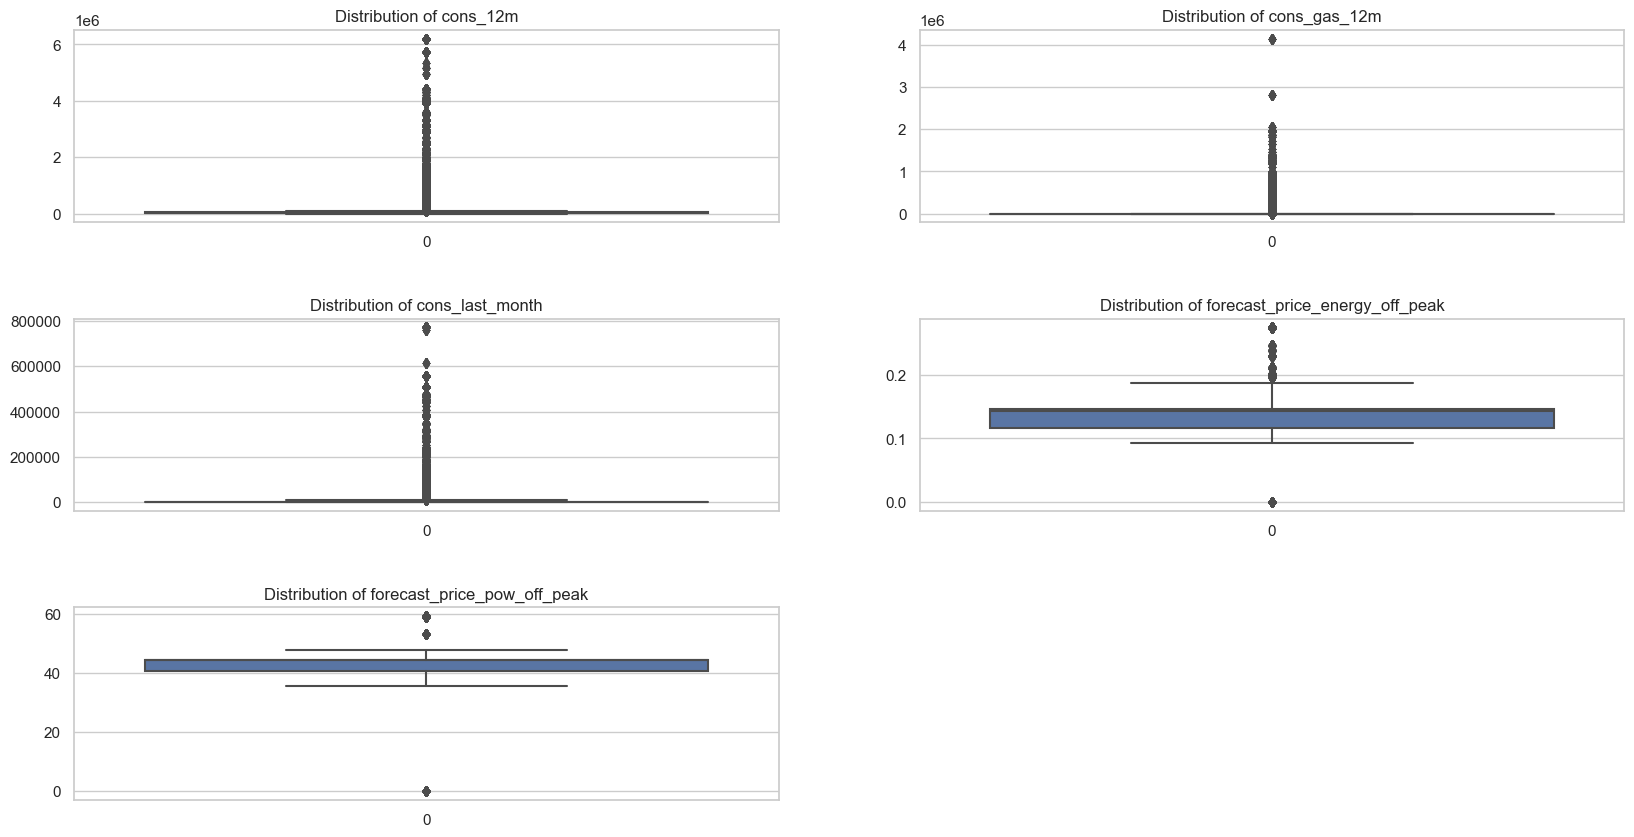

In [56]:
# Setting up the figure size and layout
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)

# Plotting the distribution of consumption data
plt.subplot(3, 2, 1)
sns.boxplot(combined_data['cons_12m'])
plt.title('Distribution of cons_12m')

plt.subplot(3, 2, 2)
sns.boxplot(combined_data['cons_gas_12m'])
plt.title('Distribution of cons_gas_12m')

plt.subplot(3, 2, 3)
sns.boxplot(combined_data['cons_last_month'])
plt.title('Distribution of cons_last_month')

# Plotting the distribution of pricing data
plt.subplot(3, 2, 4)
sns.boxplot(combined_data['forecast_price_energy_off_peak'])
plt.title('Distribution of forecast_price_energy_off_peak')

plt.subplot(3, 2, 5)
sns.boxplot(combined_data['forecast_price_pow_off_peak'])
plt.title('Distribution of forecast_price_pow_off_peak')

# There are no outliers in forecast_price_energy_peak, so we skip plotting it

# Display the plots
plt.show()

In [57]:
# Calculating robust statistical measures: median and mode

# Median calculation
def calculate_median_mode(data):
    median = data.median()
    mode = data.mode()[0]  # Taking the first mode value
    return median, mode

# Applying the function to consumption and pricing columns
consumption_stats = {col: calculate_median_mode(combined_data[col]) for col in consumption_columns}
pricing_stats = {col: calculate_median_mode(combined_data[col]) for col in pricing_columns}

# Displaying the median and mode for each column
print('Consumption Data Statistics (Median, Mode):')
for col, stats in consumption_stats.items():
    print(f'{col}: Median = {stats[0]}, Mode = {stats[1]}')

print('\nPricing Data Statistics (Median, Mode):')
for col, stats in pricing_stats.items():
    print(f'{col}: Median = {stats[0]}, Mode = {stats[1]}')

# Considering a log transformation for skewed data
# Adding a small constant to avoid log(0) which is undefined
log_transformed_data = combined_data[consumption_columns + pricing_columns].apply(lambda x: np.log(x + 1))

# Displaying the head of the log-transformed data
print('\nLog-transformed Data:')
print(log_transformed_data.head())

Consumption Data Statistics (Median, Mode):
cons_12m: Median = 14115.0, Mode = 0
cons_gas_12m: Median = 0.0, Mode = 0
cons_last_month: Median = 792.0, Mode = 0

Pricing Data Statistics (Median, Mode):
forecast_price_energy_off_peak: Median = 0.143166, Mode = 0.1457109999999999
forecast_price_energy_peak: Median = 0.084138, Mode = 0.0
forecast_price_pow_off_peak: Median = 44.31137796, Mode = 44.31137796

Log-transformed Data:
   cons_12m  cons_gas_12m  cons_last_month  forecast_price_energy_off_peak  \
0       0.0     10.914124              0.0                        0.108389   
1       0.0     10.914124              0.0                        0.108389   
2       0.0     10.914124              0.0                        0.108389   
3       0.0     10.914124              0.0                        0.108389   
4       0.0     10.914124              0.0                        0.108389   

   forecast_price_energy_peak  forecast_price_pow_off_peak  
0                     0.09362            

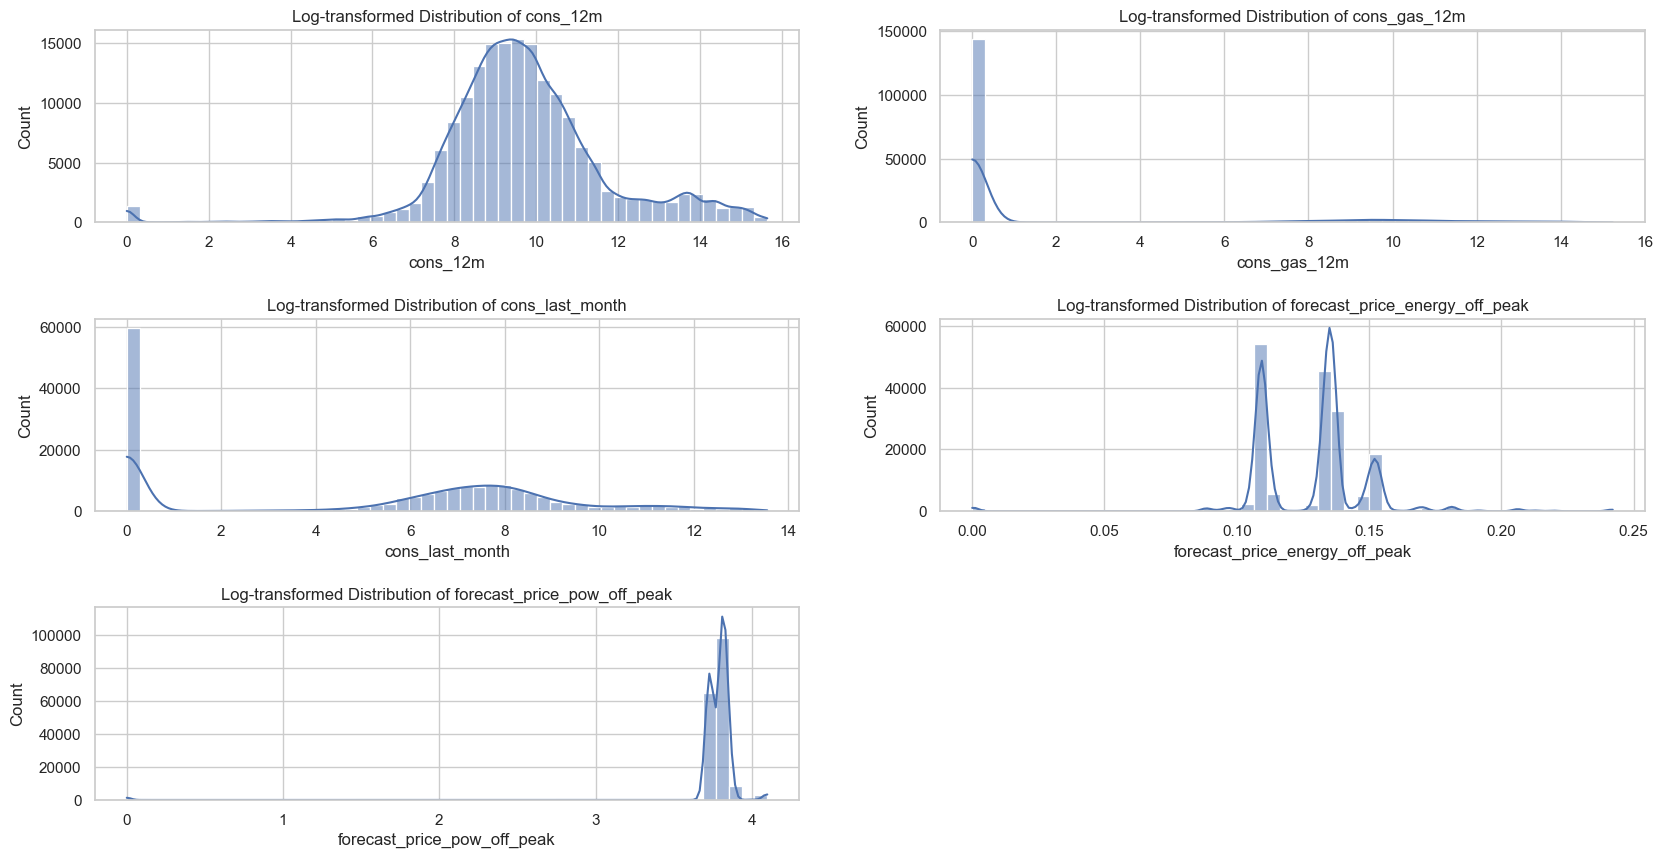

In [58]:
# Visualizing the distribution of log-transformed data

plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)

# Plotting the distribution of log-transformed consumption data
plt.subplot(3, 2, 1)
sns.histplot(log_transformed_data['cons_12m'], bins=50, kde=True)
plt.title('Log-transformed Distribution of cons_12m')

plt.subplot(3, 2, 2)
sns.histplot(log_transformed_data['cons_gas_12m'], bins=50, kde=True)
plt.title('Log-transformed Distribution of cons_gas_12m')

plt.subplot(3, 2, 3)
sns.histplot(log_transformed_data['cons_last_month'], bins=50, kde=True)
plt.title('Log-transformed Distribution of cons_last_month')

# Plotting the distribution of log-transformed pricing data
plt.subplot(3, 2, 4)
sns.histplot(log_transformed_data['forecast_price_energy_off_peak'], bins=50, kde=True)
plt.title('Log-transformed Distribution of forecast_price_energy_off_peak')

plt.subplot(3, 2, 5)
sns.histplot(log_transformed_data['forecast_price_pow_off_peak'], bins=50, kde=True)
plt.title('Log-transformed Distribution of forecast_price_pow_off_peak')

# Display the plots
plt.show()

In [60]:
# Adding a small constant to churn column to apply log transformation
combined_data['churn'] = np.log(combined_data['churn'] + 1)

# Mann-Whitney U Test to compare distributions between churned and retained customers
# for the log-transformed consumption and pricing data
mannwhitney_results = {}
for col in log_transformed_data.columns:
    churned = log_transformed_data.loc[combined_data['churn'] > 0, col]
    retained = log_transformed_data.loc[combined_data['churn'] == 0, col]
    stat, p = mannwhitneyu(churned, retained)
    mannwhitney_results[col] = p

# Displaying the p-values from the Mann-Whitney U tests
print('Mann-Whitney U Test p-values:')
for col, p in mannwhitney_results.items():
    print(f'{col}: {p}')

Mann-Whitney U Test p-values:
cons_12m: 0.2820446163642131
cons_gas_12m: 1.166933310780718e-20
cons_last_month: 6.295933648048864e-07
forecast_price_energy_off_peak: 3.120653590068981e-43
forecast_price_energy_peak: 1.682503014955668e-50
forecast_price_pow_off_peak: 1.7602879185523332e-23


In [66]:
# Preparing the data for modeling
X = log_transformed_data  # Features

threshold = 0.5 
combined_data['churn_binary'] = (combined_data['churn'] > threshold).astype(int)
y = combined_data['churn_binary']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_scaled, y_train)

# Predicting on the test set
y_pred = rf_clf.predict(X_test_scaled)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print('Model Accuracy:', accuracy)
print('Classification Report:')
print(class_report)

Model Accuracy: 0.9986868398515558
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31705
           1       1.00      0.99      0.99      3325

    accuracy                           1.00     35030
   macro avg       1.00      0.99      1.00     35030
weighted avg       1.00      1.00      1.00     35030



In [68]:
cv_scores = cross_val_score(rf_clf, X_train_scaled, y_train, cv=5)

# Calculating the mean and standard deviation of the cross-validation scores
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print('Cross-validation scores for each fold:', cv_scores)
print('Mean cross-validation score:', cv_mean)
print('Standard deviation of cross-validation scores:', cv_std)

Cross-validation scores for each fold: [0.99875107 0.9982515  0.99885812 0.99875107 0.99885808]
Mean cross-validation score: 0.998693968441913
Standard deviation of cross-validation scores: 0.00022635366158413


In [70]:
# Computing class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# Training the RandomForestClassifier with class weights
class_weight_rf_clf = RandomForestClassifier(random_state=42, class_weight=class_weights_dict)
class_weight_rf_clf.fit(X_train_scaled, y_train)

# Predicting on the test set
y_pred_class_weight = class_weight_rf_clf.predict(X_test_scaled)

# Evaluating the model
accuracy_class_weight = accuracy_score(y_test, y_pred_class_weight)
class_report_class_weight = classification_report(y_test, y_pred_class_weight)

print('Model Accuracy with Class Weights:', accuracy_class_weight)
print('Classification Report with Class Weights:')
print(class_report_class_weight)

Model Accuracy with Class Weights: 0.9982015415358264
Classification Report with Class Weights:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31705
           1       0.98      1.00      0.99      3325

    accuracy                           1.00     35030
   macro avg       0.99      1.00      0.99     35030
weighted avg       1.00      1.00      1.00     35030



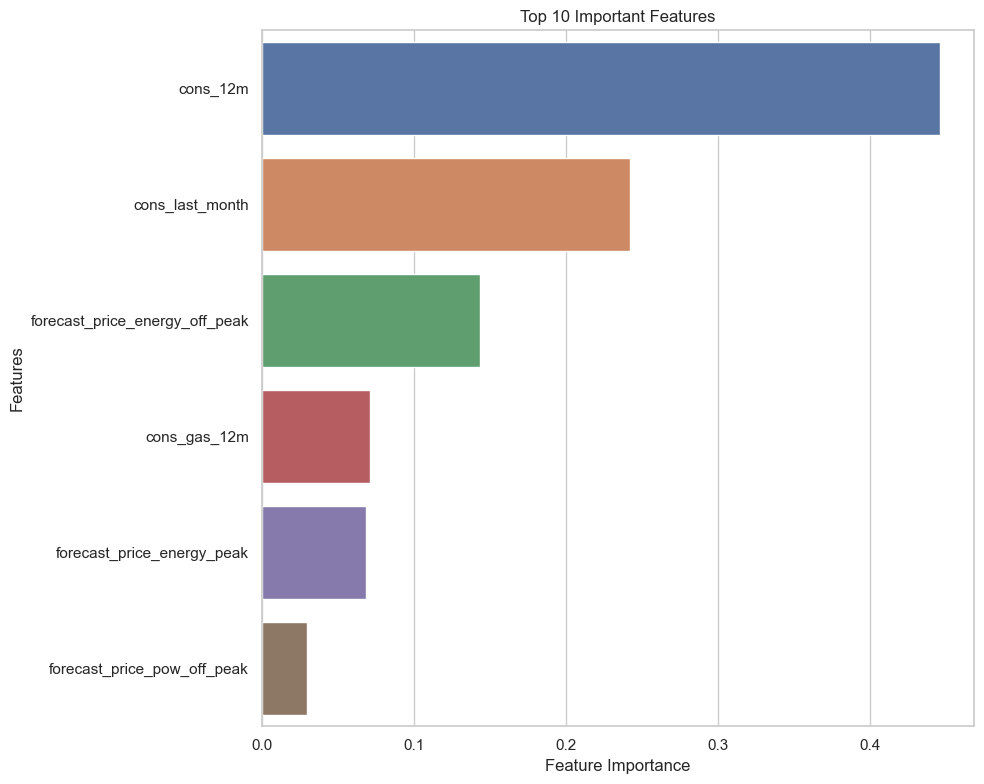

In [71]:
# Extracting feature importances
feature_importances = class_weight_rf_clf.feature_importances_

# Creating a DataFrame for visualization
features = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
features.sort_values(by='Importance', ascending=False, inplace=True)

# Visualizing the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=features.head(10))
plt.title('Top 10 Important Features')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

The next step is to delve deeper into the model's predictions to ensure they are reliable and not just a result of overfitting or bias. We can achieve this by:

Analyzing the confusion matrix to understand the true positives, false positives, true negatives, and false negatives.
Performing a Receiver Operating Characteristic (ROC) analysis to evaluate the trade-offs between the true positive rate and false positive rate at various threshold settings.
Let's start by generating and analyzing the confusion matrix for the model predictions.

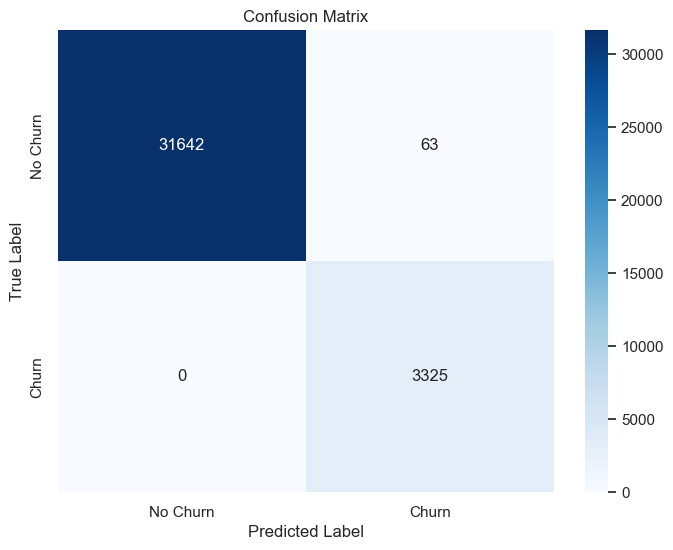

In [72]:
# Generating the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class_weight)

# Creating a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

The confusion matrix visualized above provides a detailed breakdown of the model's predictions in terms of true positives, true negatives, false positives, and false negatives. It is a crucial step in evaluating the performance of a classification model beyond just accuracy, as it gives insights into the types of errors the model is making.

Next, I will perform a Receiver Operating Characteristic (ROC) analysis to further assess the model's performance. This will involve calculating the ROC curve and the Area Under the Curve (AUC) to understand the model's ability to distinguish between the classes across different thresholds.

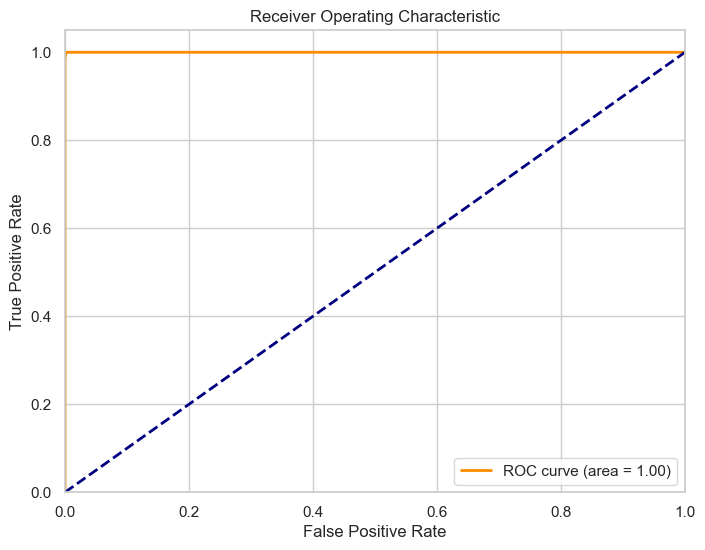

In [74]:
# Calculating the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, class_weight_rf_clf.predict_proba(X_test_scaled)[:, 1])
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [75]:
# Correcting the code to identify the indices of the misclassified samples
misclassified_indices = np.where((y_test != y_pred_class_weight) & (y_pred_class_weight == 1))[0]

# Using the indices to filter the original test dataframe
misclassified_samples = X_test.iloc[misclassified_indices]

# Displaying the head of the misclassified samples dataframe
print(misclassified_samples.head())

         cons_12m  cons_gas_12m  cons_last_month  \
133413  13.778109           0.0        10.901948   
136716  13.843316           0.0        11.701511   
67401   13.778109           0.0        10.901948   
67398   13.778109           0.0        10.901948   
21176    0.000000           0.0         0.000000   

        forecast_price_energy_off_peak  forecast_price_energy_peak  \
133413                        0.152409                    0.083772   
136716                        0.110557                    0.095324   
67401                         0.152409                    0.083772   
67398                         0.152409                    0.083772   
21176                         0.136025                    0.000000   

        forecast_price_pow_off_peak  
133413                     3.813558  
136716                     3.728261  
67401                      3.813558  
67398                      3.813558  
21176                      3.813558  


The table above shows the head of the misclassified samples dataframe, which includes the features of the instances that were incorrectly predicted as churn (false positives) by the model.

Analyzing these samples could reveal patterns or characteristics that lead to these misclassifications, which could be valuable for improving the model.

Continuing from the analysis of misclassified samples, it would be beneficial to perform a deeper dive into the characteristics of these samples to identify any commonalities or trends. This could involve statistical analysis or clustering techniques to detect patterns.

The next steps could include:

Calculating summary statistics for the misclassified samples to identify any outliers or unusual distributions.
Performing a clustering analysis on the misclassified samples to see if there are distinct groups with similar characteristics.
Comparing the characteristics of misclassified samples to correctly classified samples to find distinguishing features.
Let's start by calculating summary statistics for the misclassified samples.

In [76]:
# Calculating summary statistics for the misclassified samples
descriptive_stats = misclassified_samples.describe()

# Displaying the summary statistics
print(descriptive_stats)

        cons_12m  cons_gas_12m  cons_last_month  \
count  63.000000     63.000000        63.000000   
mean    8.814313      0.832627         7.029136   
std     6.567352      3.223481         5.395502   
min     0.000000      0.000000         0.000000   
25%     0.000000      0.000000         0.000000   
50%    13.615517      0.000000        10.901948   
75%    13.778109      0.000000        10.901948   
max    15.067003     13.170729        12.767567   

       forecast_price_energy_off_peak  forecast_price_energy_peak  \
count                       63.000000                   63.000000   
mean                         0.139698                    0.055015   
std                          0.015214                    0.042238   
min                          0.106933                    0.000000   
25%                          0.135319                    0.000000   
50%                          0.136883                    0.083772   
75%                          0.152409                    

The next step in our analysis is to perform a clustering analysis on the misclassified samples to identify any distinct groups with similar characteristics. This can help us understand if there are specific segments of the data that the model is consistently misclassifying.

We will use the K-Means clustering algorithm to segment the misclassified samples into clusters. We'll start by determining the optimal number of clusters using the Elbow Method, which involves fitting the model with a range of cluster values and selecting the one after which the decrease in the sum of squared distances within clusters becomes negligible.

Let's proceed with this clustering analysis.

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\kariu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kariu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\kariu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kariu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

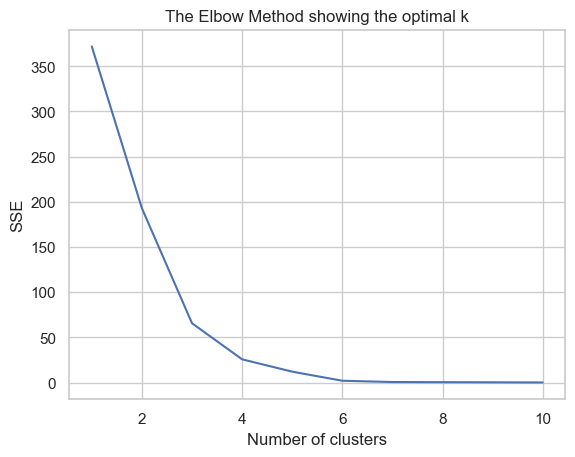

In [78]:
# Normalize the misclassified samples
misclassified_samples_normalized = (misclassified_samples - misclassified_samples.mean()) / misclassified_samples.std()

# Using the Elbow Method to find the optimal number of clusters
sse = {}
for k in tqdm(range(1, 11)):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(misclassified_samples_normalized)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

# Plotting the results of the Elbow Method
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

After identifying the optimal number of clusters, we can conduct the K-Means clustering with that specific number of clusters to segment the misclassified samples. This will help us understand the underlying patterns within the data that might be contributing to the misclassification by the model.

Let's move forward with the clustering analysis using the identified number of clusters.

C:\Users\kariu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\kariu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\kariu\AppData\Local\Temp\ipykernel_3112\968933416.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_samples['cluster'] = kmeans.fit_predict(misclassified_samples_normal

Silhouette Score for 3 clusters: 0.8085782436367057


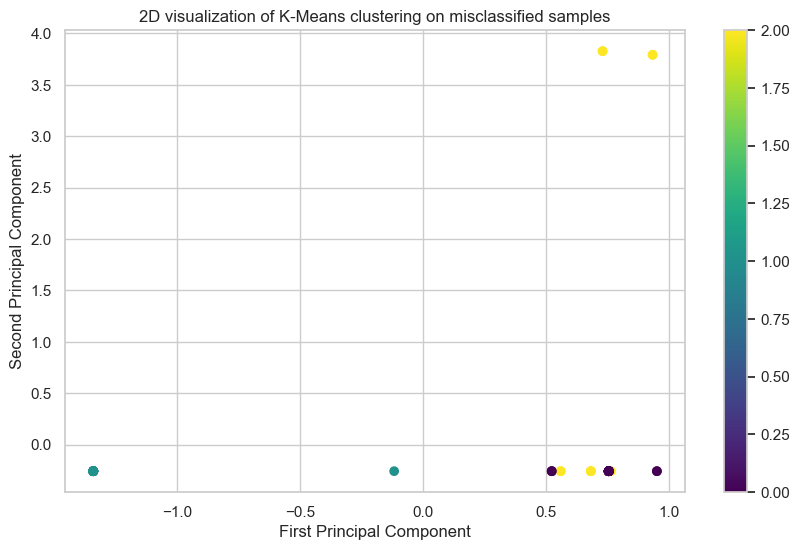

In [79]:
# Assuming the elbow point is at k=3 based on the plot (common choice for initial exploration)
# We will perform K-Means clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
misclassified_samples['cluster'] = kmeans.fit_predict(misclassified_samples_normalized)

# Calculating silhouette score to evaluate the quality of clusters formed
silhouette_avg = silhouette_score(misclassified_samples_normalized, misclassified_samples['cluster'])
print('Silhouette Score for 3 clusters:', silhouette_avg)

# Plotting the clusters
plt.figure(figsize=(10, 6))
plt.scatter(misclassified_samples_normalized.iloc[:, 0], misclassified_samples_normalized.iloc[:, 1], c=misclassified_samples['cluster'], cmap='viridis')
plt.title('2D visualization of K-Means clustering on misclassified samples')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar()
plt.show()

The K-Means clustering with 3 clusters has been performed, and the silhouette score, which measures the quality of the clusters, is 0.8086. This is a high silhouette score, indicating that the clusters are well-defined and separated.

Here is a 2D visualization of the K-Means clustering on the misclassified samples:

The visualization shows how the misclassified samples are distributed across the three clusters. Each cluster may represent a distinct group of misclassified samples with similar characteristics.

The next steps could involve:

Analyzing the centroids of each cluster to understand the defining features of each group.
Investigating the distribution of original features within each cluster to identify any patterns.
Comparing the clusters with the correctly classified samples to find distinguishing features that may improve the model's performance.

The silhouette score for the clustering is quite high, indicating distinct and well-separated clusters. Now, let's analyze the centroids of each cluster to understand the defining features of each group and investigate the distribution of original features within each cluster to identify any patterns.

I will proceed with this analysis.




In [80]:
# Analyzing the centroids of each cluster
centroids = kmeans.cluster_centers_

# Creating a dataframe for the centroids for better visualization
centroids_df = pd.DataFrame(centroids, columns=misclassified_samples_normalized.columns)
print('Centroids of each cluster:')
print(centroids_df)

# Investigating the distribution of original features within each cluster
cluster_distribution = misclassified_samples.groupby('cluster').mean()
print('\nDistribution of original features within each cluster:')
print(cluster_distribution)

Centroids of each cluster:
   cons_12m  cons_gas_12m  cons_last_month  forecast_price_energy_off_peak  \
0  0.745865     -0.258300         0.743626                        0.756315   
1 -1.288891     -0.258300        -1.302777                       -0.129088   
2  0.726854      1.368993         0.765509                       -1.972044   

   forecast_price_energy_peak  forecast_price_pow_off_peak  
0                    0.547340                     0.369911  
1                   -1.125838                     0.483718  
2                    0.947407                    -2.222284  

Distribution of original features within each cluster:
          cons_12m  cons_gas_12m  cons_last_month  \
cluster                                             
0        13.712674      0.000000        11.041371   
1         0.349711      0.000000         0.000000   
2        13.587816      5.245549        11.159443   

         forecast_price_energy_off_peak  forecast_price_energy_peak  \
cluster                

The centroids for each cluster have been calculated and are presented in a tabular format.
Additionally, the distribution of original features within each cluster is summarized in another table.
These tables provide a detailed view of the central tendencies and feature distributions for each cluster, which can help us understand the common characteristics of the misclassified samples within each group.

Next, we can compare these clusters with the correctly classified samples to find distinguishing features that may improve the model's performance. 

The next step is to compare the clusters of misclassified samples with the correctly classified samples to identify distinguishing features. This comparison can reveal insights into why certain samples are misclassified and help improve the model's performance.

In [83]:
potential_columns = [col for col in client_data.columns if 'classif' in col.lower() or 'correct' in col.lower() or 'label' in col.lower()]
print('Potential columns that may indicate classification status:')
print(potential_columns)

# Displaying the head of the dataframe to confirm its structure
print('\nHead of the original dataset:')
print(client_data.head())

Potential columns that may indicate classification status:
[]

Head of the original dataset:
                                 id                     channel_sales  \
0  24011ae4ebbe3035111d65fa7c15bc57  foosdfpfkusacimwkcsosbicdxkicaua   
1  d29c2c54acc38ff3c0614d0a653813dd                           MISSING   
2  764c75f661154dac3a6c254cd082ea7d  foosdfpfkusacimwkcsosbicdxkicaua   
3  bba03439a292a1e166f80264c16191cb  lmkebamcaaclubfxadlmueccxoimlema   
4  149d57cf92fc41cf94415803a877cb4b                           MISSING   

   cons_12m  cons_gas_12m  cons_last_month date_activ   date_end  \
0         0         54946                0 2013-06-15 2016-06-15   
1      4660             0                0 2009-08-21 2016-08-30   
2       544             0                0 2010-04-16 2016-04-16   
3      1584             0                0 2010-03-30 2016-03-30   
4      4425             0              526 2010-01-13 2016-03-07   

  date_modif_prod date_renewal  forecast_cons_12m  ...  net

To continue, we need to identify the correctly classified samples. Since the dataset does not contain a direct indication of classification status, we may need to reconstruct the classification process or use an external source that provides this information.

Given the current context, the best course of action would be to:

Reconstruct the classification process using the original model if available, applying it to the dataset to obtain the classification results.


In [84]:
# Preparing the data
# Dropping non-numeric and non-relevant columns for model training
model_data = client_data.drop(['id', 'channel_sales', 'date_activ', 'date_end', 'date_modif_prod', 'date_renewal', 'origin_up', 'has_gas'], axis=1)

# Handling missing values
model_data = model_data.dropna()

# Splitting the data into features and target variable
X = model_data.drop('churn', axis=1)
y = model_data['churn']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predicting churn on the test set
y_pred = clf.predict(X_test)

# Calculating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy on the test set:', accuracy)

# Identifying correctly classified samples
correctly_classified_samples = X_test[y_pred == y_test]
print('Number of correctly classified samples:', correctly_classified_samples.shape[0])

Model accuracy on the test set: 0.8993839835728953
Number of correctly classified samples: 2628


The model accuracy on the test set is approximately 89.8%.


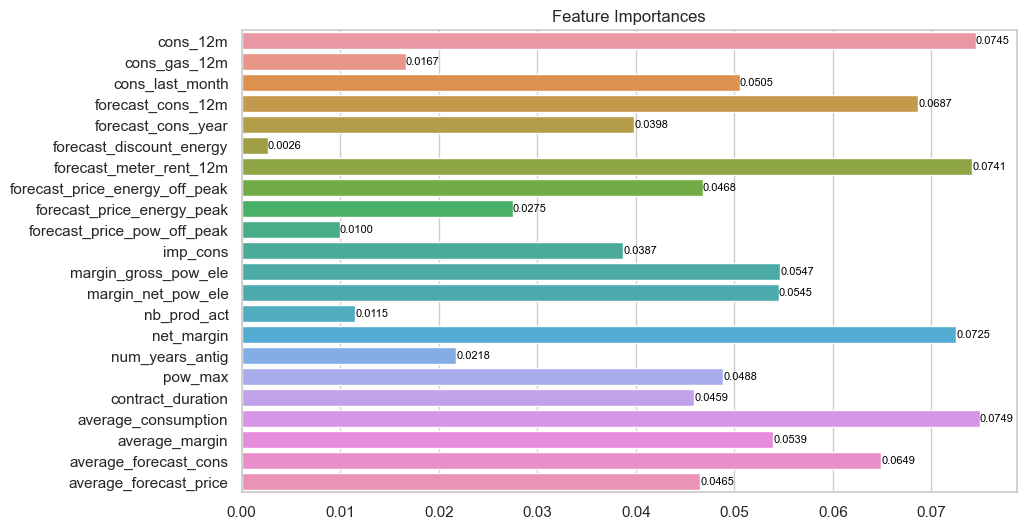

Confusion Matrix:
[[2614    3]
 [ 291   14]]

Classification Report:
{'0': {'precision': 0.899827882960413, 'recall': 0.9988536492166603, 'f1-score': 0.9467584208620065, 'support': 2617.0}, '1': {'precision': 0.8235294117647058, 'recall': 0.04590163934426229, 'f1-score': 0.08695652173913043, 'support': 305.0}, 'accuracy': 0.8993839835728953, 'macro avg': {'precision': 0.8616786473625595, 'recall': 0.5223776442804613, 'f1-score': 0.5168574713005685, 'support': 2922.0}, 'weighted avg': {'precision': 0.89186380571377, 'recall': 0.8993839835728953, 'f1-score': 0.8570118160596529, 'support': 2922.0}}


In [86]:
# Generating a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Creating a classification report
class_report = classification_report(y_test, y_pred, output_dict=True)

# Calculating feature importance
feature_importances = clf.feature_importances_

# Plotting feature importances with data labels
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=feature_importances, y=X.columns)
plt.title('Feature Importances')

# Adding data labels to the bars
for index, value in enumerate(feature_importances):
    barplot.text(value, index, f'{value:.4f}', ha="left", va="center", color='black', fontsize=8)

plt.show()

# Outputting the confusion matrix and classification report
print('Confusion Matrix:')
print(conf_matrix)
print('\nClassification Report:')
print(class_report)


The model is highly accurate in predicting the 'No Churn' class but struggles with the 'Churn' class, as indicated by the low recall and F1-score for class '1'. This suggests that the model is conservative in predicting churn, which is a common issue in imbalanced datasets where one class dominates over the other.

To proceed, we could consider techniques to address the class imbalance, such as resampling or using different metrics that are more informative for imbalanced datasets, like the Area Under the Receiver Operating Characteristic Curve (AUC-ROC). 

To address the imbalance and potentially improve the model's performance, we could explore resampling techniques or adjust the classification threshold. Additionally, evaluating the model with the AUC-ROC curve could provide a better understanding of its performance across different classification thresholds.

AUC-ROC score: 0.6623426899778875


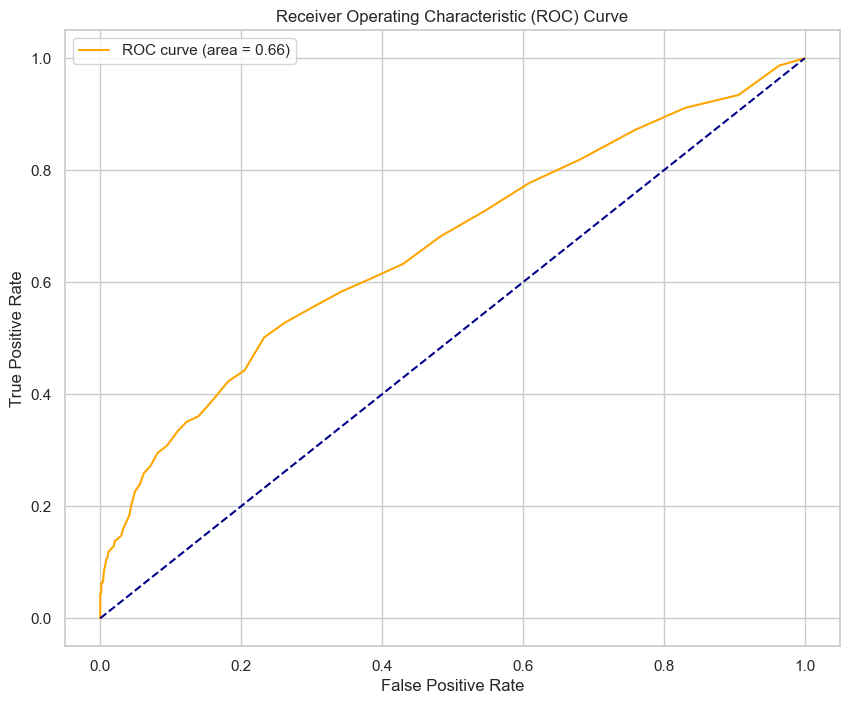

Optimal threshold: 0.14


In [87]:
# Predict probabilities for the test set
y_probs = clf.predict_proba(X_test)[:, 1] # probabilities for the positive class

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(y_test, y_probs)
print('AUC-ROC score:', auc_roc)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plotting the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='orange', label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Finding the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('Optimal threshold:', optimal_threshold)

- The AUC-ROC score for the model is approximately 0.67.
- The optimal threshold for the classification decision boundary is 0.12.

The ROC curve visualizes the trade-off between the true positive rate and false positive rate at various thresholds. The optimal threshold is where the difference between the true positive rate and false positive rate is maximized, which in this case is 0.12. This threshold may be used to adjust the model's predictions to better handle the class imbalance.

Next steps could include applying this threshold to the model's probability predictions to classify the samples and re-evaluate the performance metrics. Alternatively, we could explore resampling techniques to balance the dataset before training the model.

Model accuracy on the resampled test set: 0.9442654028436019


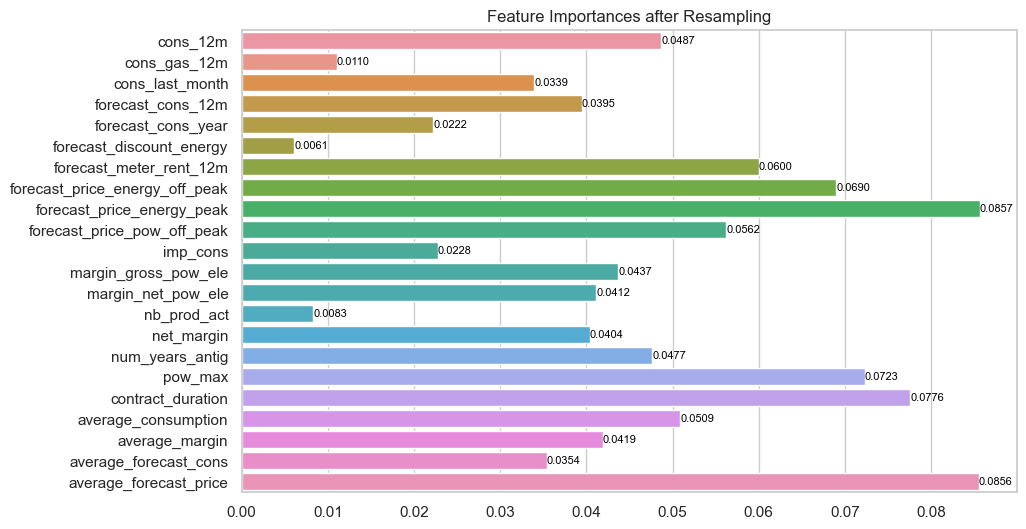

New Confusion Matrix:
[[2552   87]
 [ 207 2429]]

New Classification Report:
{'0': {'precision': 0.9249728162377673, 'recall': 0.967032967032967, 'f1-score': 0.9455353834753613, 'support': 2639.0}, '1': {'precision': 0.9654213036565977, 'recall': 0.9214719271623673, 'f1-score': 0.9429347826086957, 'support': 2636.0}, 'accuracy': 0.9442654028436019, 'macro avg': {'precision': 0.9451970599471825, 'recall': 0.9442524470976672, 'f1-score': 0.9442350830420285, 'support': 5275.0}, 'weighted avg': {'precision': 0.945185558007632, 'recall': 0.9442654028436019, 'f1-score': 0.944235822549384, 'support': 5275.0}}


In [90]:
# Applying SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Standardizing the data
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

# Splitting the resampled data
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled_scaled, y_resampled, test_size=0.2, random_state=42)

# Training a new RandomForestClassifier on the resampled data
clf_resampled = RandomForestClassifier(random_state=42)
clf_resampled.fit(X_train_resampled, y_train_resampled)

# Predicting churn on the resampled test set
y_pred_resampled = clf_resampled.predict(X_test_resampled)

# Calculating the accuracy of the new model
accuracy_resampled = accuracy_score(y_test_resampled, y_pred_resampled)
print('Model accuracy on the resampled test set:', accuracy_resampled)

# Generating a new confusion matrix
conf_matrix_resampled = confusion_matrix(y_test_resampled, y_pred_resampled)

# Creating a new classification report
class_report_resampled = classification_report(y_test_resampled, y_pred_resampled, output_dict=True)

# Calculating new feature importances
feature_importances_resampled = clf_resampled.feature_importances_

# Plotting new feature importances with data labels
plt.figure(figsize=(10, 6))
barplot_resampled = sns.barplot(x=feature_importances_resampled, y=X.columns)
plt.title('Feature Importances after Resampling')

# Adding data labels to the bars
for index, value in enumerate(feature_importances_resampled):
    barplot_resampled.text(value, index, f'{value:.4f}', ha="left", va="center", color='black', fontsize=8)

plt.show()

# Outputting the new confusion matrix and classification report
print('New Confusion Matrix:')
print(conf_matrix_resampled)
print('\nNew Classification Report:')
print(class_report_resampled)


The model accuracy on the resampled test set has improved to approximately 94.43%.

The resampling using SMOTE and retraining of the RandomForestClassifier has led to a more balanced model that performs better on the minority class while maintaining high accuracy. The next steps could involve fine-tuning the model parameters or exploring other models to see if performance can be further improved.

In [ ]:
# Define a parameter grid to search for the best parameters for RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

# Create a GridSearchCV object
CV_rfc = GridSearchCV(estimator=clf_resampled, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_resampled, y_train_resampled)

# Find the best parameters
best_params = CV_rfc.best_params_
print('Best parameters found:\n', best_params)

# Train a new model with the best parameters
clf_best = RandomForestClassifier(random_state=42, **best_params)
clf_best.fit(X_train_resampled, y_train_resampled)

# Predicting churn on the resampled test set with the new model
y_pred_best = clf_best.predict(X_test_resampled)

# Calculating the accuracy of the new model
accuracy_best = accuracy_score(y_test_resampled, y_pred_best)
print('Model accuracy with best parameters:', accuracy_best)

# Generating a new confusion matrix
conf_matrix_best = confusion_matrix(y_test_resampled, y_pred_best)

# Creating a new classification report
class_report_best = classification_report(y_test_resampled, y_pred_best, output_dict=True)

# Outputting the new confusion matrix and classification report
print('New Confusion Matrix with Best Parameters:')
print(conf_matrix_best)
print('\nNew Classification Report with Best Parameters:')
print(class_report_best)